# Prediction of Mutation Effect: Minimizing the impact of randomization
## Single Protein Multiple Mutation


<b><i class="fa fa-folder-o" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Location</b><br>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">C:\Users\ibrah\Documents\GitHub\Predicting-Mutation-Effects\src</code>
</p>

<b><i class="far fa-file" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Name</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">Minimize_randomization_25.ipynb</code>
</p>

<b><i class="far fa-calendar-alt" area-hidden="true" style="color:#1976D2"> </i>&nbsp; Last Edited</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">August 20th, 2021</code>
</p>


<div class="alert alert-block" style="background-color: #F5F5F5; border: 1px solid; padding: 10px; border-color: #E0E0E0">
    <b><i class="fa fa-compass" aria-hidden="true" style="color:#404040"></i></b>&nbsp; <b style="color: #404040">Purpose </b> <br>
<div>

    
- [x] $\textit{mutation effect label}$ prediction using Random Forest algorithm.
    

- [x] Classification will be $\textit{Disrupting vs (No effect + Increasing)}$.
    > $\textit{Disrupting} → 0$\
    > $\textit{No effect + Increasing} → 1$\
    > $\textit{Decreasing} → \textit{ignored}$
    
    
- [x] Evaluate the performane of the model.
    
- [x] We use SHAP in feature selection
    
    
- [x] Apply on Cancer Datasets
    > For now, a portion of all BRCA. But will be updated.
     
- [ ] We measure the impact of randomization by repeating whole experiment with multiple runs. 
    
**Dependent files:**
* Training (mutations) data:
    - *training_data_M1.txt*


* Target (Cancer) data: 
    - *BRCA_INTERFACE_A2.txt*

## Setup

In [30]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from IPython.display import display
from tqdm.notebook import tqdm
from helpers.common import print_annotation, get_file_path
from helpers.displayers import display_label_counts, display_labels, visualize_label_counts
from helpers.construct_data import prepare_data_spsm, prepare_data_spmm

# To make this notebook's output stable across runs
# [1, 5(?), 42, 96]
NUM_EXPERIMENT_REPEAT = 50
# random_seed_list = [1, 5, 42, 96, 46, 167, 115,  48,  26,  88, 103, 100, 117,  79,   4, 166,  46,
#                     39,  31,  18,  22, 120, 113, 197, 194]
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)

# PATHS
PROJECT_COMMON_FILE_DIR = "../data/"
MUTATIONS_PATH = "training_data_M1.txt"
INITIAL_COLUMNS_PATH = "../data/initial_columns_59.csv"
BRCA_PATH = "../data/BRCA_INTERFACE_A2.txt"

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading the Datasets

### 1. Training Data: Mutations

In [2]:
# Read Training Data
mutations = pd.read_csv(get_file_path(PROJECT_COMMON_FILE_DIR, MUTATIONS_PATH), sep='\t')

# Size of dataframe
print_annotation(f"Size of dataframe: {mutations.shape}")

# First 5 entries
mutations.head()


Size of dataframe: (1101, 104)
------------------------------


,Mutation_Effect_Label,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
1,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
2,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
3,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
4,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627


### 2. Target Data

Cancer datasets whose feature columns have been collected from ELASPIC.

**BRCA**

In [3]:
# Read BRCA Data
brca = pd.read_csv(get_file_path(PROJECT_COMMON_FILE_DIR, BRCA_PATH), sep='\t')

# Size of dataframe
print_annotation(f"Size of dataframe: {brca.shape}")

# First 3 entries
brca.head(3)


Size of dataframe: (4452, 103)
------------------------------


,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,Domain_clan,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


**COAD** // to be added

**OV** // to be added

## Data Cleaning

### Select column names

In [4]:
initial_columns_train = pd.read_csv(INITIAL_COLUMNS_PATH)['0'].to_list()
# ['Mutation_Effect_Label'] + ['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID'] + remaining feature list
initial_columns_train_with_protein_mutation_interactor = [initial_columns_train[0]] + ['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID'] + initial_columns_train[1:]

In [5]:
initial_columns_target = initial_columns_train.copy()
initial_columns_target.remove('Mutation_Effect_Label')

In [6]:
initial_columns_train_with_protein_mutation_interactor

['Mutation_Effect_Label',
 'UniProt_ID',
 'Mutation',
 'Interactor_UniProt_ID',
 'Template_sequence_identity',
 'Alignment_score',
 'Interactor_template_sequence_identity',
 'Interactor_alignment_score',
 'Final_ddG',
 'ProtBert_score',
 'ProteinSolver_score',
 'EL2_score',
 'Model/DOPE_score',
 'Provean_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'pcv_vdW_wt',
 'pcv_vdW_mut',
 'pcv_vdW_self_wt',
 'pcv_vdW_self_mut',
 'dg_wt',
 'backbone_hbond_wt',
 'sidechain_hbond_wt',
 'van_der_waals_wt',
 'electrostatics_wt',
 'solvation_polar_wt',
 'solvation_hydrophobic_wt',
 'van_der_waals_clashes_wt',
 'entropy_sidechain_wt',
 'entropy_mainchain_wt',
 'torsional_clash_wt',
 'backbone_clash_wt',
 'helix_dipole_wt',
 'electrostatic_kon_wt',
 'energy_ionisation_wt',
 'number_of_residues_wt',
 'dg_mut',
 'backbone_hbond_mut',
 'sidechain_hbond_mut',
 'van_der_waals_mut',
 'electrostatics_mut',
 'solvation_polar_mut',
 'solvation_hydrophobic_mut',
 'van_der_w

### Reduce Columns

#### Train (Mutations) Data

In [7]:
# Declare train data using selected column names
train_data = mutations[initial_columns_train_with_protein_mutation_interactor].copy()

# Size of dataframe
print_annotation(f"Size of dataframe: {train_data.shape}")

# First 5 entries
train_data.head()


Size of dataframe: (1101, 62)
-----------------------------


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
1,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155-1,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
2,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155-2,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
3,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155-3,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
4,mutation decreasing rate(MI:1130),P63000,Q61L,Q14155-5,1.0,0.921875,0.2432,0.253076,1.72835,0.9981741060182685,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627


In [8]:
# Dropping the duplicates
train_data.drop_duplicates(keep="first", inplace=True)

Ensuring that there is no duplicated row.

In [9]:
train_data[train_data.duplicated()].empty  # True, duplicate is empty

True

In [10]:
train_data.shape

(1101, 62)

#### Target (Cancer) Data

**BRCA**

In [11]:
# Declare target_brca data using selected column names
target_brca_data = brca[initial_columns_target].copy(deep=True)

# Size of dataframe
print_annotation(f"Size of dataframe: {target_brca_data.shape}")

# First 3 entries
target_brca_data.head(3)


Size of dataframe: (4452, 58)
-----------------------------


,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.5343,0.530760,0.9857,0.936088,0.730056,0.957609918201342,0.741487597115338,1.76123535329794,-1.137780,-4.726,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,0.5884,0.579682,0.9928,0.993160,0.795178,0.927518657408655,0.0195063538849354,1.12969519749536,-0.929739,-4.726,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,0.5884,0.579682,0.9928,0.993160,1.03054,0.927518657408655,0.0146090686321259,1.27036083414174,-0.896799,-4.726,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


## Data Preprocessing

* [x] Not all selected columns are interpreted as numeric, so coerce them to numeric.

### Mutation Effect Label Binning

Mutation Effect label binning is only applied to train_data.

* [x] Apply Label binning.
    > $\textit{Disruptive} → 0$\
    > $\textit{No effect + Increasing} → 1$\
    > $\textit{Decreasing} → \textit{ignored}$


For $\textit{mutation effect label}$ we have following categories:

In [12]:
# Displaying possible label categories.
display_labels(train_data)

,Mutation_Effect_Label
0,mutation disrupting(MI:0573)
1,mutation decreasing(MI:0119)
2,mutation disrupting strength(MI:1128)
3,mutation decreasing strength(MI:1133)
4,mutation with no effect(MI:2226)
5,disrupting
6,mutation increasing(MI:0382)
7,mutation increasing strength(MI:1132)
8,mutation decreasing rate(MI:1130)
9,mutation disrupting rate(MI:1129)


Applying binning operation on $\textit{mutation effect label}$ column in $\textit{mutations}$ data with described rule below \
    - $\textit{Disrupting} → 0$\
    - $\textit{No effect + Increasing} → 1$\
    - $\textit{Decreasing} → \textit{dropped}$\
    - $\textit{Causing} → \textit{dropped}$\
yields following data frame:

In [13]:
labels_to_bins = { 
    "mutation disrupting(MI:0573)": 0,
    "mutation decreasing(MI:0119)": "IGNORED",
    "mutation disrupting strength(MI:1128)": 0,
    "mutation decreasing strength(MI:1133)": "IGNORED",
    "mutation with no effect(MI:2226)": 1,
    "disrupting": 0,
    "mutation increasing(MI:0382)": 1,
    "mutation increasing strength(MI:1132)": 1,
    "mutation decreasing rate(MI:1130)": "IGNORED",
    "mutation disrupting rate(MI:1129)": 0,
    "mutation causing(MI:2227)": "IGNORED",
    "mutation increasing rate(MI:1131)": 1}

replace_map = {"Mutation_Effect_Label": labels_to_bins}

In [14]:
# Size of dataframe before binning.
print_annotation(f"Size of dataframe before binning: {train_data.shape}")

# Modifications will be done on train_data_binned.
train_data_binned = train_data.copy()

# Replace the labels as described above.
train_data_binned.replace(replace_map, inplace=True)

# Drop the entries with "IGNORED": 'mutation cusing' in this case.
train_data_binned = train_data_binned[train_data_binned["Mutation_Effect_Label"] != "IGNORED"]

# Reset index of the dataframe to avoid any possible errors
train_data_binned.reset_index(drop=True, inplace=True)

# Size of dataframe after binning.
print_annotation(f"Size of dataframe after binning: {train_data_binned.shape}")

# First 5 rows of binned data.
train_data_binned.head()


Size of dataframe before binning: (1101, 62)
--------------------------------------------

Size of dataframe after binning: (740, 62)
------------------------------------------


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.09227252565324306,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749150385265,...,329.0,47.61770,47.21160,70.2902,70.2461,464.47,400.03,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.695710,0.2882971949657076,...,453.0,68.21080,68.19710,59.2321,59.1774,510.69,298.82,809.51,3.03938,3.24435
3,0,Q96QK1,F534D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.695710,0.2882971949657076,...,453.0,68.21080,68.19710,59.2321,59.1774,510.69,298.82,809.51,3.03938,3.24435
4,0,O43521-3,G66A,Q07812,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025405526161194,...,202.0,3.74828,3.76142,41.5937,41.5937,405.51,273.74,679.245,3.37301,3.22505


Confirming replacement of values are properly done. $\textit{Mutation_Effect_Label}$ only contains of $0$ or $1$.

In [15]:
train_data_binned["Mutation_Effect_Label"].value_counts()

0    540
1    200
Name: Mutation_Effect_Label, dtype: int64

### Type Coercion

Some columns have been interpreted as `object` type, eventhough they are actually numeric.

In [16]:
# Train (mutations) data
set(train_data_binned.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [17]:
# Target Cancer data
set(target_brca_data.dtypes), # set(target_coad_data.dtypes), set(target_ov_data.dtypes)

({dtype('int64'), dtype('float64'), dtype('O')},)

These non-numeric interpereted columns will be coerced. $\textit{NaN}$ values will be converted to $0$.

In [18]:
features = [column for column in train_data_binned.columns if column not in ['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID']]

In [19]:
features_brca = [column for column in target_brca_data.columns if column not in ['UniProt_ID', 'Mutation', 'Interactor_UniProt_ID']]

In [20]:
# Get column names where its type is *not* int or float, i.e. whose type is object.
coerce_numeric_cols = set([cname for cname in features if train_data_binned[cname].dtype not in ['int64', 'float64']]
                        + [cname for cname in features_brca if target_brca_data[cname].dtype not in ['int64', 'float64']]) # \ 
#                         + [cname for cname in target_coad_data.columns if target_coad_data[cname].dtype not in ['int64', 'float64']]\
#                         + [cname for cname in target_ov_data.columns if target_ov_data[cname].dtype not in ['int64', 'float64']])

# Remove target variable from the list
coerce_numeric_cols = coerce_numeric_cols - {"Mutation_Effect_Label", "UniProt_ID", "Mutation", "Interactor_UniProt_ID"}

for cname in coerce_numeric_cols:
    train_data_binned[cname] = pd.to_numeric(train_data_binned[cname], errors='coerce')
    target_brca_data[cname] = pd.to_numeric(target_brca_data[cname], errors='coerce')
#     target_coad_data[cname] = pd.to_numeric(target_coad_data[cname], errors='coerce')
#     target_ov_data[cname] = pd.to_numeric(target_ov_data[cname], errors='coerce')
    
train_data_binned.fillna(0, inplace=True)
target_brca_data.fillna(0, inplace=True)
# target_coad_data.fillna(0, inplace=True)
# target_ov_data.fillna(0, inplace=True)

Now all columns are interpreted as numeric type, except "_UniProt_ID_", "_Mutation_", "_Interactor_UniProt_ID_"

In [21]:
# Train (mutations) data
set(train_data_binned.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [22]:
# Target Cancer data
set(target_brca_data.dtypes), # set(target_coad_data.dtypes), set(target_ov_data.dtypes)

({dtype('int64'), dtype('float64')},)

In [23]:
# all features are numeric.
train_data_binned.dtypes[features]

Mutation_Effect_Label                      int64
Template_sequence_identity               float64
Alignment_score                          float64
Interactor_template_sequence_identity    float64
Interactor_alignment_score               float64
Final_ddG                                float64
ProtBert_score                           float64
ProteinSolver_score                      float64
EL2_score                                float64
Model/DOPE_score                         float64
Provean_score                            float64
Matrix_score                             float64
Solvent_accessibility_wt                 float64
Solvent_accessibility_mut                float64
pcv_vdW_wt                                 int64
pcv_vdW_mut                                int64
pcv_vdW_self_wt                            int64
pcv_vdW_self_mut                           int64
dg_wt                                    float64
backbone_hbond_wt                        float64
sidechain_hbond_wt  

In [24]:
# all features are numeric.
target_brca_data.dtypes[features_brca]

Template_sequence_identity               float64
Alignment_score                          float64
Interactor_template_sequence_identity    float64
Interactor_alignment_score               float64
Final_ddG                                float64
ProtBert_score                           float64
ProteinSolver_score                      float64
EL2_score                                float64
Model/DOPE_score                         float64
Provean_score                            float64
Matrix_score                             float64
Solvent_accessibility_wt                 float64
Solvent_accessibility_mut                float64
pcv_vdW_wt                                 int64
pcv_vdW_mut                                int64
pcv_vdW_self_wt                            int64
pcv_vdW_self_mut                           int64
dg_wt                                    float64
backbone_hbond_wt                        float64
sidechain_hbond_wt                       float64
van_der_waals_wt    

### Processed train data and Label Counts

From now on, training data is refered as `data_processed`.

In [25]:
# Declaing `data_processed`.
data_processed = train_data_binned.copy()

# Size of processed data.
print_annotation(f"Size of processed data: {data_processed.shape}")

# First 5 rows of binned data.
data_processed.head()


Size of processed data: (740, 62)
---------------------------------


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.695710,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
3,0,Q96QK1,F534D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.695710,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
4,0,O43521-3,G66A,Q07812,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025,...,202.0,3.74828,3.76142,41.5937,41.5937,405.510,273.740,679.245,3.37301,3.22505


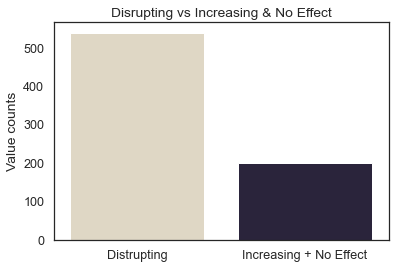

In [26]:
visualize_label_counts(data_processed)

In [27]:
display_label_counts(data_processed)

,Mutation_Effect_Label,Counts
Disrupting,0,540
Increasing + No Effect,1,200


In [29]:
# data_processed.to_csv('processed_data_740.csv', index=False)

## Data Creation with Unique Proteins

In [33]:
# TODO: I could also use numpy array to store the sampled train dataframes
# because later on, one operation can be applied to each of them simultaneously. e.g. dropping column.
sampled_train_data_list = []
for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    sampled_train_data = prepare_data_spsm(data_processed, random_seed=i)
    sampled_train_data_list.append(sampled_train_data)

  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
len(sampled_train_data_list)

50

---

Here, we desire training data to have unique $\textit{(protein, mutation)}$. 

In [32]:
# Introducing new column `Protein_Mutation`, containing (protein, mutation) tuple.
data_processed['Protein_Mutation'] = data_processed.apply(lambda x: (x['UniProt_ID'], x['Mutation']), axis=1)
data_processed.head()

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut,Protein_Mutation
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293,"(Q9BPZ3, F118A)"
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123,"(P01116, Y40C)"
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.695710,0.288297,...,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435,"(Q96QK1, F534D)"
3,0,Q96QK1,F534D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.695710,0.288297,...,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435,"(Q96QK1, F534D)"
4,0,O43521-3,G66A,Q07812,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025,...,3.74828,3.76142,41.5937,41.5937,405.510,273.740,679.245,3.37301,3.22505,"(O43521-3, G66A)"


In [36]:
# Get the unique (protein, mutation) pairs from `Protein_Mutation` column.
unique_protein_mutation_pairs = list(data_processed['Protein_Mutation'].unique())

# Number of unique (protein, mutation) pairs.
print('Number of `unique_protein_mutation_pairs`:', len(unique_protein_mutation_pairs))

# First five (protein, mutation) pairs
print(unique_protein_mutation_pairs[:5])

Number of `unique_protein_mutation_pairs`: 369
[('Q9BPZ3', 'F118A'), ('P01116', 'Y40C'), ('Q96QK1', 'F534D'), ('O43521-3', 'G66A'), ('Q13418', 'Q362H')]


There are $369$ unique $\textit{(protein, mutation)}$ pairs in `Protein_Mutation` column. Now, we will re-construct the training data where it will have $369$ rows, i.e. one row for each unique unique $\textit{(protein, mutation)}$ pair. In the case where multiple row option possible, we randomly select one.

In [37]:
sampled_row_dataframes = []
for unique_protein_mutation in unique_protein_mutation_pairs:
    sampled_row_dataframes.append(data_processed[data_processed['Protein_Mutation'] == unique_protein_mutation].sample())

In [38]:
# Merge row dataframes into single dataframe, stack rows on top of each other.
sampled_train_data = pd.concat(sampled_row_dataframes)

# Reset index of the dataframe to avoid any possible errors
sampled_train_data.reset_index(drop=True, inplace=True)

# Dimensions of dataframe
print_annotation(f"Dimensions of sampled_dataframe: {sampled_train_data.shape}")

# First five entries
sampled_train_data.head()


Dimensions of sampled_dataframe: (369, 63)
------------------------------------------


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut,Protein_Mutation
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293,"(Q9BPZ3, F118A)"
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123,"(P01116, Y40C)"
2,0,Q96QK1,F534D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.695710,0.288297,...,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435,"(Q96QK1, F534D)"
3,0,O43521-3,G66A,P10415,0.8077,0.607148,0.4611,0.457246,0.510358,-0.044520,...,5.88486,6.57183,93.3738,93.3738,414.305,244.975,659.285,3.55303,3.19191,"(O43521-3, G66A)"
4,1,Q13418,Q362H,Q9NVD7,0.9925,0.971054,1.0000,0.961240,0.621791,0.206189,...,60.07690,60.06430,33.8017,33.8017,406.135,174.195,580.330,3.39874,3.39874,"(Q13418, Q362H)"


---

In [35]:
sampled_train_data_to_label_counts = {}
for i, sampled_train_data in enumerate(sampled_train_data_list):
    label_counts = sampled_train_data['Mutation_Effect_Label'].value_counts()
    sampled_train_data_to_label_counts["SAMPLED_TRAIN_DATA_" + str(i+1)] = [label_counts.loc[0], label_counts.loc[1]]


In [36]:
experiment_statistics_data = pd.DataFrame(sampled_train_data_to_label_counts).T
experiment_statistics_data.columns = ['Disrupting', 'Increasing+NoEff']
experiment_statistics_data

,Disrupting,Increasing+NoEff
SAMPLED_TRAIN_DATA_1,107,57
SAMPLED_TRAIN_DATA_2,102,62
SAMPLED_TRAIN_DATA_3,102,62
SAMPLED_TRAIN_DATA_4,104,60
SAMPLED_TRAIN_DATA_5,105,59
SAMPLED_TRAIN_DATA_6,104,60
SAMPLED_TRAIN_DATA_7,106,58
SAMPLED_TRAIN_DATA_8,103,61
SAMPLED_TRAIN_DATA_9,107,57
SAMPLED_TRAIN_DATA_10,107,57


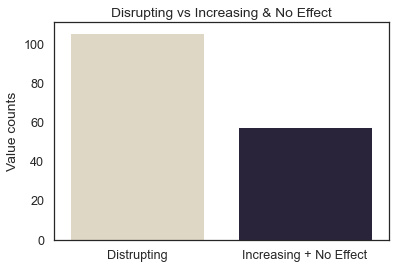

In [37]:
# todo: maybe avg of them??? e.g. 107.32 to 59.97
visualize_label_counts(sampled_train_data)

## Prepare the Train Data for Machine Learning Algorithms

In [38]:
from helpers.prepare_data_for_ML import prepare_data_machine_learning

In [39]:
# data_materials = prepare_data_machine_learning(sampled_train_data, 'spsm', random_seed=42) # <======== will change here for each datasets.

In [42]:
prepared_dataframes = []
label_proportions_dataframes = []
Xs = []
ys = []
Xs_train = []
ys_train = []
Xs_valid = []
ys_valid = []
Xs_train_random = []
ys_train_random = []
Xs_valid_random = []
ys_valid_random = []

for i in range(NUM_EXPERIMENT_REPEAT):
    
    # display(sampled_train_data.head())
    
    data_materials = prepare_data_machine_learning(sampled_train_data_list[i], 'SPSM', random_seed=i)
    
    prepared_dataframes.append(data_materials['data_prepared'])
    
    label_proportions_dataframes.append(data_materials['label_proportions_data'])
    
    # All entries
    Xs.append(data_materials['X'])
    ys.append(data_materials['y'])

    # Stratified version
    Xs_train.append(data_materials['X_train'])
    ys_train.append(data_materials['y_train'])
    Xs_valid.append(data_materials['X_valid'])
    ys_valid.append(data_materials['y_valid'])

    # Randomized version
    Xs_train_random.append(data_materials['X_train_random'])
    ys_train_random.append(data_materials['y_train_random'])
    Xs_valid_random.append(data_materials['X_valid_random'])
    ys_valid_random.append(data_materials['y_valid_random'])


In [154]:
all([Xs_train[i].shape == (131, 58) for i in range(NUM_EXPERIMENT_REPEAT)])

True

In [155]:
all([Xs_valid[i].shape == (33, 58) for i in range(NUM_EXPERIMENT_REPEAT)])

True

# Classification

In [43]:
feature_columns = list(Xs[0].columns)

## Initial Insights

In [44]:
# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [45]:
from helpers.machine_learning_utils import cross_validation_options

In [46]:

# Plotting feature importance in barplot
def plot_feature_importances(feature_importances):
    attributes = feature_columns
    feature_imp_series = pd.Series(feature_importances,
                               index = attributes).sort_values(ascending=False)

    plt.figure(figsize=(5, 20))
    sns.set(style="white", font_scale=1.15)  # white, dark, whitegrid, darkgrid, ticks
    sns.barplot(x=feature_imp_series, y=feature_imp_series.index, palette="ch:s=-.2,r=.6")
    plt.xlabel('Feature Importance Scores')
    plt.ylabel('Variables')
    plt.title('Feature Importances')
    plt.show()
    
    
# Plotting top n feature importance in barplot
def plot_top_feature_importances(feature_importances, top_n=10, figsize=None):
    attributes = feature_columns
    feature_imp_series = pd.Series(feature_importances,
                               index = attributes).sort_values(ascending=False)
    
    figsize = (5 , top_n//3) if not figsize else (5, 5)
    
    sns.set(style="white", font_scale=1.15)  # white, dark, whitegrid, darkgrid, ticks
    feature_imp_series_top_n = feature_imp_series[:top_n]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp_series_top_n, y=feature_imp_series_top_n.index, palette="ch:s=-.2,r=.6")
    plt.xlabel('Feature Importance Scores')
    plt.ylabel('Variables')
    plt.title('Feature Importances (top {})'.format(top_n))
    plt.show()

In [47]:
for i in range(NUM_EXPERIMENT_REPEAT):
    # Initial scoring: X_train, y_train with prediction of X_valid
    forest_clf_inital = RandomForestClassifier(random_state=i)

    forest_clf_inital.fit(Xs_train[i], ys_train[i])

    forest_predictions = forest_clf_inital.predict(Xs_valid[i])

    print("Balanced accuracy score : {:.4f}".format(balanced_accuracy_score(ys_valid[i], forest_predictions)))
    print("Accuracy score\t\t: {:.4f}".format(accuracy_score(ys_valid[i], forest_predictions)))
    print("================================")

Balanced accuracy score : 0.6591
Accuracy score		: 0.7273
Balanced accuracy score : 0.6190
Accuracy score		: 0.6970
Balanced accuracy score : 0.7857
Accuracy score		: 0.8182
Balanced accuracy score : 0.6190
Accuracy score		: 0.6970
Balanced accuracy score : 0.5357
Accuracy score		: 0.6364
Balanced accuracy score : 0.7083
Accuracy score		: 0.7879
Balanced accuracy score : 0.7500
Accuracy score		: 0.8182
Balanced accuracy score : 0.8095
Accuracy score		: 0.8485
Balanced accuracy score : 0.7273
Accuracy score		: 0.8182
Balanced accuracy score : 0.5455
Accuracy score		: 0.6364
Balanced accuracy score : 0.6845
Accuracy score		: 0.7576
Balanced accuracy score : 0.6131
Accuracy score		: 0.6667
Balanced accuracy score : 0.6667
Accuracy score		: 0.7576
Balanced accuracy score : 0.7262
Accuracy score		: 0.7879
Balanced accuracy score : 0.5227
Accuracy score		: 0.6364
Balanced accuracy score : 0.5655
Accuracy score		: 0.6061
Balanced accuracy score : 0.6964
Accuracy score		: 0.7273
Balanced accur

In [48]:
def evaluate_cross_val(X_train_param, y_train_param, cv_option_param):
        
    # Cross Validation options
    cv_option, n_jobs = cross_validation_options(cv_option_param, -1)
    
    # Model
    forest_clf = RandomForestClassifier(random_state=42)
    
    # Cross-validation Accuracy and Balanced Accuracy Scores
    forest_scores_bas = cross_val_score(forest_clf, 
                                        X_train_param, y_train_param,
                                        cv=cv_option, scoring="balanced_accuracy", n_jobs=n_jobs)

    forest_scores_as = cross_val_score(forest_clf, 
                                       X_train_param, y_train_param,
                                       cv=cv_option, scoring="accuracy", n_jobs=n_jobs)
    
    # Print scores and averages
    print("Balanced accuracy score AVG : {:.4f}".format(forest_scores_bas.mean()))
#     print(forest_scores_bas)
    print("Accuracy score AVG          : {:.4f}".format(forest_scores_as.mean()))
#     print(forest_scores_as)

In [50]:
for i in range(NUM_EXPERIMENT_REPEAT):
    evaluate_cross_val(Xs[i], ys[i], "skf_10")
    print("====================================")

Balanced accuracy score AVG : 0.6570
Accuracy score AVG          : 0.7004
Balanced accuracy score AVG : 0.6823
Accuracy score AVG          : 0.7434
Balanced accuracy score AVG : 0.6554
Accuracy score AVG          : 0.7055
Balanced accuracy score AVG : 0.6814
Accuracy score AVG          : 0.7673
Balanced accuracy score AVG : 0.6761
Accuracy score AVG          : 0.7489
Balanced accuracy score AVG : 0.6873
Accuracy score AVG          : 0.7331
Balanced accuracy score AVG : 0.6459
Accuracy score AVG          : 0.7312
Balanced accuracy score AVG : 0.6675
Accuracy score AVG          : 0.7081
Balanced accuracy score AVG : 0.6385
Accuracy score AVG          : 0.7500
Balanced accuracy score AVG : 0.7089
Accuracy score AVG          : 0.7360
Balanced accuracy score AVG : 0.6512
Accuracy score AVG          : 0.7074
Balanced accuracy score AVG : 0.6673
Accuracy score AVG          : 0.7445
Balanced accuracy score AVG : 0.6198
Accuracy score AVG          : 0.7316
Balanced accuracy score AVG : 0.6823
A

In [177]:
# evaluate_cross_val(X, y, "skf_10")

NameError: name 'y' is not defined

In [ ]:
# evaluate_cross_val(X, y, "skf_10")

In [ ]:
# evaluate_cross_val(X, y, "skf_10")

In [ ]:
# evaluate_cross_val(X, y, "skf_10")

In [ ]:
# evaluate_cross_val(X_train, y_train, "skf_5")

In [156]:
# evaluate_cross_val(X_train, y_train, "skf_5")

Balanced accuracy score AVG : 0.6375
Accuracy score AVG          : 0.7088


In [52]:
# evaluate_cross_val(X_train, y_train, "skf_5")

Balanced accuracy score AVG : 0.6519
Accuracy score AVG          : 0.7407


In [76]:
# evaluate_cross_val(X, y, "skf_10")

Balanced accuracy score AVG : 0.7024
Accuracy score AVG          : 0.8267


In [50]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import seaborn as sns

def cross_val_confusion_matrix_via(model_param, X_train_param, y_train_param,
                                   return_report=False):
    
    skf = StratifiedKFold(shuffle=True, n_splits=10)
    y_pred_temp = cross_val_predict(model_param, X_train_param, y_train_param, cv=skf)
    
    label_names = ["Disrupting", "NoEffect+Increasing"]
       
    sns.heatmap(confusion_matrix(y_train_param, y_pred_temp), annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)
    plt.title(r'$\mathbf{Confusion\ Matrix}$', fontsize=16, fontweight='bold')
    plt.ylabel('Actual', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted', fontsize=16, fontweight='bold')
    plt.show()
    
    if return_report:
        print(classification_report(y_train_param, y_pred_temp, target_names=label_names))
  

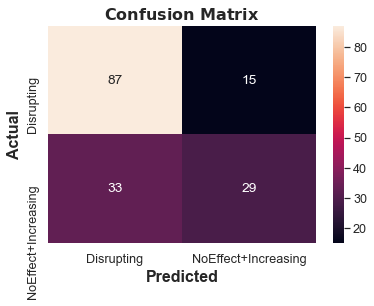

                     precision    recall  f1-score   support

         Disrupting       0.72      0.85      0.78       102
NoEffect+Increasing       0.66      0.47      0.55        62

           accuracy                           0.71       164
          macro avg       0.69      0.66      0.67       164
       weighted avg       0.70      0.71      0.69       164



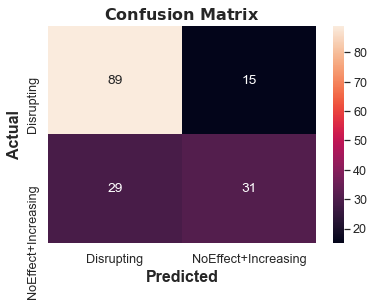

                     precision    recall  f1-score   support

         Disrupting       0.75      0.86      0.80       104
NoEffect+Increasing       0.67      0.52      0.58        60

           accuracy                           0.73       164
          macro avg       0.71      0.69      0.69       164
       weighted avg       0.72      0.73      0.72       164



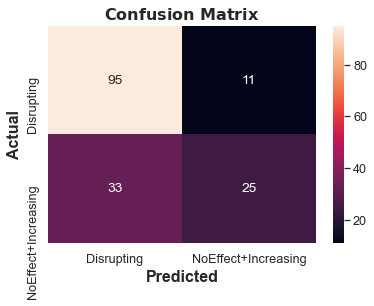

                     precision    recall  f1-score   support

         Disrupting       0.74      0.90      0.81       106
NoEffect+Increasing       0.69      0.43      0.53        58

           accuracy                           0.73       164
          macro avg       0.72      0.66      0.67       164
       weighted avg       0.73      0.73      0.71       164



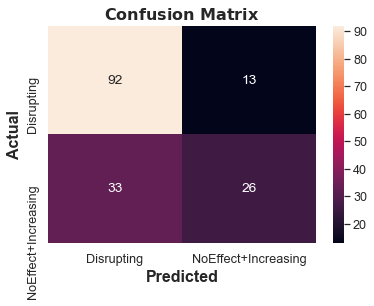

                     precision    recall  f1-score   support

         Disrupting       0.74      0.88      0.80       105
NoEffect+Increasing       0.67      0.44      0.53        59

           accuracy                           0.72       164
          macro avg       0.70      0.66      0.67       164
       weighted avg       0.71      0.72      0.70       164



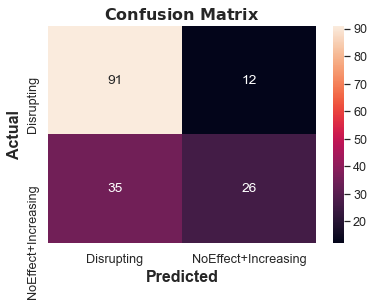

                     precision    recall  f1-score   support

         Disrupting       0.72      0.88      0.79       103
NoEffect+Increasing       0.68      0.43      0.53        61

           accuracy                           0.71       164
          macro avg       0.70      0.65      0.66       164
       weighted avg       0.71      0.71      0.69       164



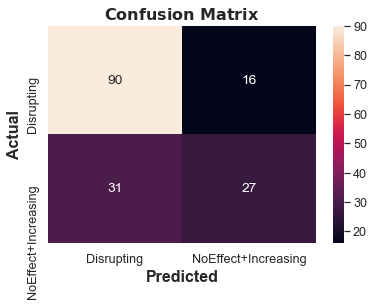

                     precision    recall  f1-score   support

         Disrupting       0.74      0.85      0.79       106
NoEffect+Increasing       0.63      0.47      0.53        58

           accuracy                           0.71       164
          macro avg       0.69      0.66      0.66       164
       weighted avg       0.70      0.71      0.70       164



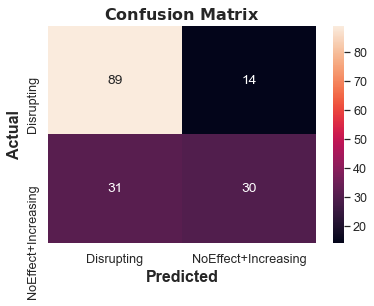

                     precision    recall  f1-score   support

         Disrupting       0.74      0.86      0.80       103
NoEffect+Increasing       0.68      0.49      0.57        61

           accuracy                           0.73       164
          macro avg       0.71      0.68      0.68       164
       weighted avg       0.72      0.73      0.71       164



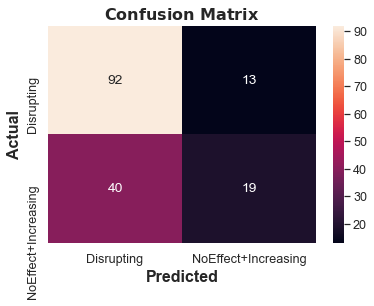

                     precision    recall  f1-score   support

         Disrupting       0.70      0.88      0.78       105
NoEffect+Increasing       0.59      0.32      0.42        59

           accuracy                           0.68       164
          macro avg       0.65      0.60      0.60       164
       weighted avg       0.66      0.68      0.65       164



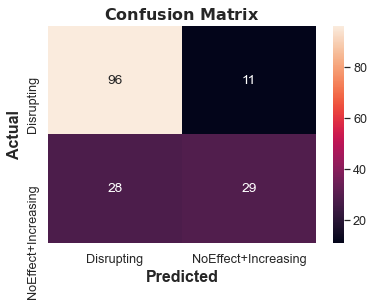

                     precision    recall  f1-score   support

         Disrupting       0.77      0.90      0.83       107
NoEffect+Increasing       0.72      0.51      0.60        57

           accuracy                           0.76       164
          macro avg       0.75      0.70      0.71       164
       weighted avg       0.76      0.76      0.75       164



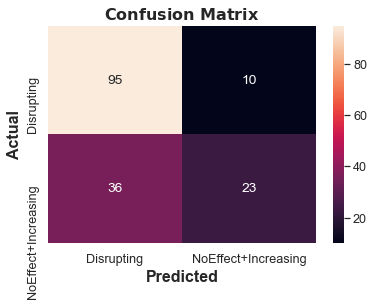

                     precision    recall  f1-score   support

         Disrupting       0.73      0.90      0.81       105
NoEffect+Increasing       0.70      0.39      0.50        59

           accuracy                           0.72       164
          macro avg       0.71      0.65      0.65       164
       weighted avg       0.72      0.72      0.70       164



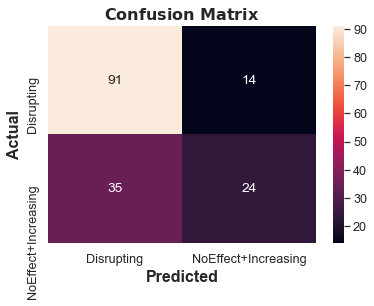

                     precision    recall  f1-score   support

         Disrupting       0.72      0.87      0.79       105
NoEffect+Increasing       0.63      0.41      0.49        59

           accuracy                           0.70       164
          macro avg       0.68      0.64      0.64       164
       weighted avg       0.69      0.70      0.68       164



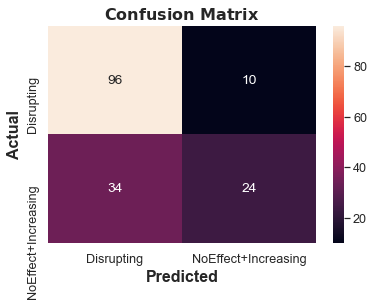

                     precision    recall  f1-score   support

         Disrupting       0.74      0.91      0.81       106
NoEffect+Increasing       0.71      0.41      0.52        58

           accuracy                           0.73       164
          macro avg       0.72      0.66      0.67       164
       weighted avg       0.73      0.73      0.71       164



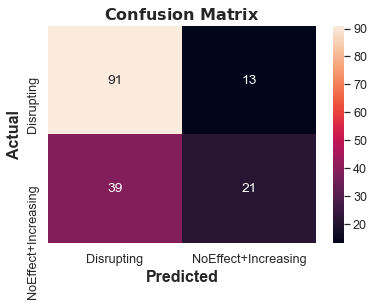

                     precision    recall  f1-score   support

         Disrupting       0.70      0.88      0.78       104
NoEffect+Increasing       0.62      0.35      0.45        60

           accuracy                           0.68       164
          macro avg       0.66      0.61      0.61       164
       weighted avg       0.67      0.68      0.66       164



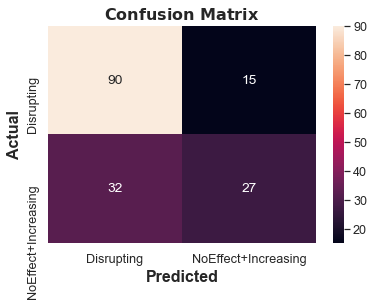

                     precision    recall  f1-score   support

         Disrupting       0.74      0.86      0.79       105
NoEffect+Increasing       0.64      0.46      0.53        59

           accuracy                           0.71       164
          macro avg       0.69      0.66      0.66       164
       weighted avg       0.70      0.71      0.70       164



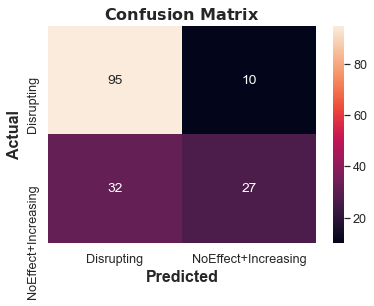

                     precision    recall  f1-score   support

         Disrupting       0.75      0.90      0.82       105
NoEffect+Increasing       0.73      0.46      0.56        59

           accuracy                           0.74       164
          macro avg       0.74      0.68      0.69       164
       weighted avg       0.74      0.74      0.73       164



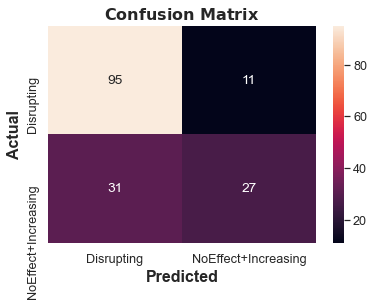

                     precision    recall  f1-score   support

         Disrupting       0.75      0.90      0.82       106
NoEffect+Increasing       0.71      0.47      0.56        58

           accuracy                           0.74       164
          macro avg       0.73      0.68      0.69       164
       weighted avg       0.74      0.74      0.73       164



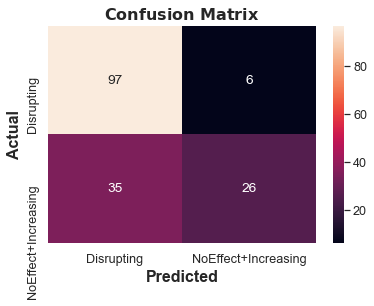

                     precision    recall  f1-score   support

         Disrupting       0.73      0.94      0.83       103
NoEffect+Increasing       0.81      0.43      0.56        61

           accuracy                           0.75       164
          macro avg       0.77      0.68      0.69       164
       weighted avg       0.76      0.75      0.73       164



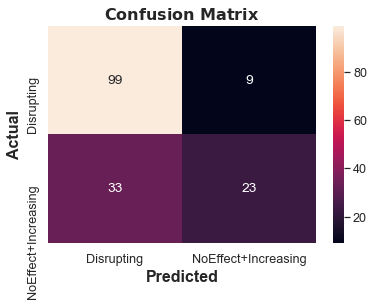

                     precision    recall  f1-score   support

         Disrupting       0.75      0.92      0.83       108
NoEffect+Increasing       0.72      0.41      0.52        56

           accuracy                           0.74       164
          macro avg       0.73      0.66      0.67       164
       weighted avg       0.74      0.74      0.72       164



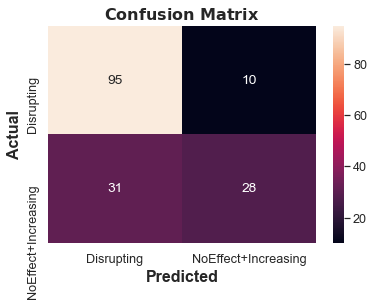

                     precision    recall  f1-score   support

         Disrupting       0.75      0.90      0.82       105
NoEffect+Increasing       0.74      0.47      0.58        59

           accuracy                           0.75       164
          macro avg       0.75      0.69      0.70       164
       weighted avg       0.75      0.75      0.73       164



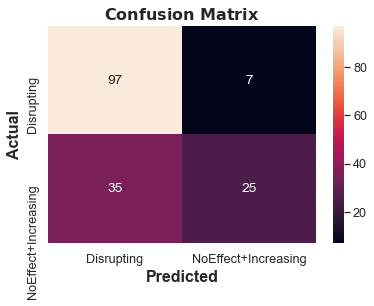

                     precision    recall  f1-score   support

         Disrupting       0.73      0.93      0.82       104
NoEffect+Increasing       0.78      0.42      0.54        60

           accuracy                           0.74       164
          macro avg       0.76      0.67      0.68       164
       weighted avg       0.75      0.74      0.72       164



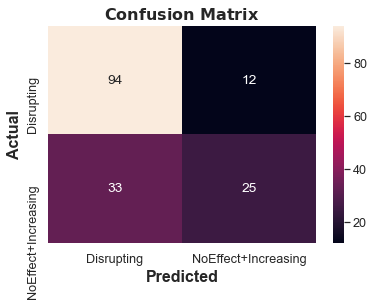

                     precision    recall  f1-score   support

         Disrupting       0.74      0.89      0.81       106
NoEffect+Increasing       0.68      0.43      0.53        58

           accuracy                           0.73       164
          macro avg       0.71      0.66      0.67       164
       weighted avg       0.72      0.73      0.71       164



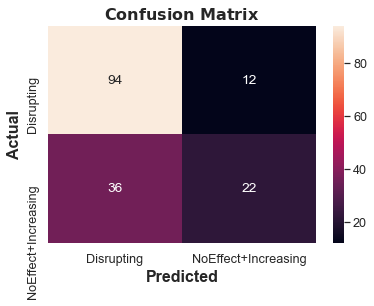

                     precision    recall  f1-score   support

         Disrupting       0.72      0.89      0.80       106
NoEffect+Increasing       0.65      0.38      0.48        58

           accuracy                           0.71       164
          macro avg       0.69      0.63      0.64       164
       weighted avg       0.70      0.71      0.68       164



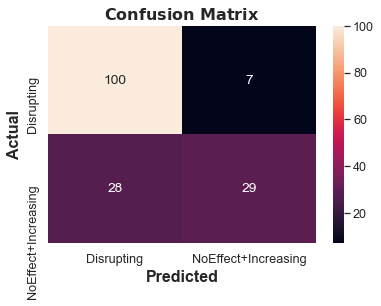

                     precision    recall  f1-score   support

         Disrupting       0.78      0.93      0.85       107
NoEffect+Increasing       0.81      0.51      0.62        57

           accuracy                           0.79       164
          macro avg       0.79      0.72      0.74       164
       weighted avg       0.79      0.79      0.77       164



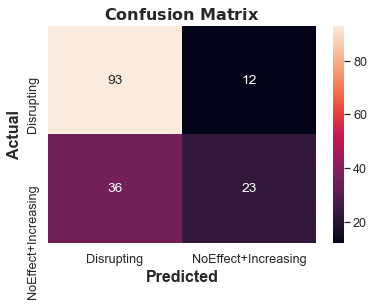

                     precision    recall  f1-score   support

         Disrupting       0.72      0.89      0.79       105
NoEffect+Increasing       0.66      0.39      0.49        59

           accuracy                           0.71       164
          macro avg       0.69      0.64      0.64       164
       weighted avg       0.70      0.71      0.68       164



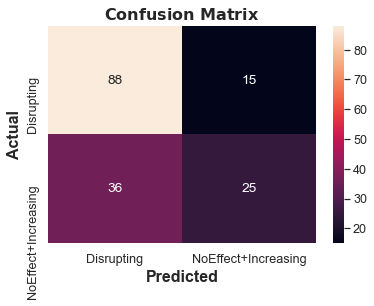

                     precision    recall  f1-score   support

         Disrupting       0.71      0.85      0.78       103
NoEffect+Increasing       0.62      0.41      0.50        61

           accuracy                           0.69       164
          macro avg       0.67      0.63      0.64       164
       weighted avg       0.68      0.69      0.67       164



In [52]:
for i, seed in zip(range(NUM_EXPERIMENT_REPEAT), random_seed_list):
    cross_val_confusion_matrix_via(RandomForestClassifier(random_state=seed),
                                   Xs[i], ys[i], return_report=True)
    print("=====================================================")

In [54]:
cross_val_confusion_matrix_via(RandomForestClassifier(random_state=42),
                               X, y, return_report=True)

NameError: name 'X' is not defined

## Shap Waterfall

In [51]:
# Import the package
import shap
shap.initjs()

In [51]:
# model = RandomForestClassifier(random_state=42)
# model.fit(Xs[0], ys[0])
# del model

In [52]:
def create_waterfall_plot(samples, X_param, y_param):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_param, y_param)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

    shap.summary_plot(shap_values[1], samples)

In [53]:
# create_waterfall_plot(Xs[0], ys[0])

In [54]:
len(Xs)

50

In [55]:
# shap_values_list = []
# for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
#     model = RandomForestClassifier(random_state=42)
#     model.fit(Xs[i], ys[i])
#     explainer = shap.TreeExplainer(model)
#     shap_values_list.append(explainer.shap_values(Xs[i], approximate=False, check_additivity=False))

In [55]:
shap_values_train_list = []
for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    model = RandomForestClassifier(random_state=42)
    model.fit(Xs_train[i], ys_train[i])
    explainer = shap.TreeExplainer(model)
    shap_values_train_list.append(explainer.shap_values(Xs_train[i], approximate=False, check_additivity=False))

  0%|          | 0/50 [00:00<?, ?it/s]

In [57]:
num_rows, num_cols = 10, 5

plt.figure(figsize=(20, 3))
# plt.subplots_adjust(wspace=6.0, hspace=0.2)
for ind, shap_values in tqdm(enumerate(shap_values_train_list), total=len(shap_values_train_list)):
    plt.subplot(num_rows, num_cols, ind+1)
    shap.summary_plot(shap_values[1], Xs_train[ind], show=False)

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 576x684 with 100 Axes>

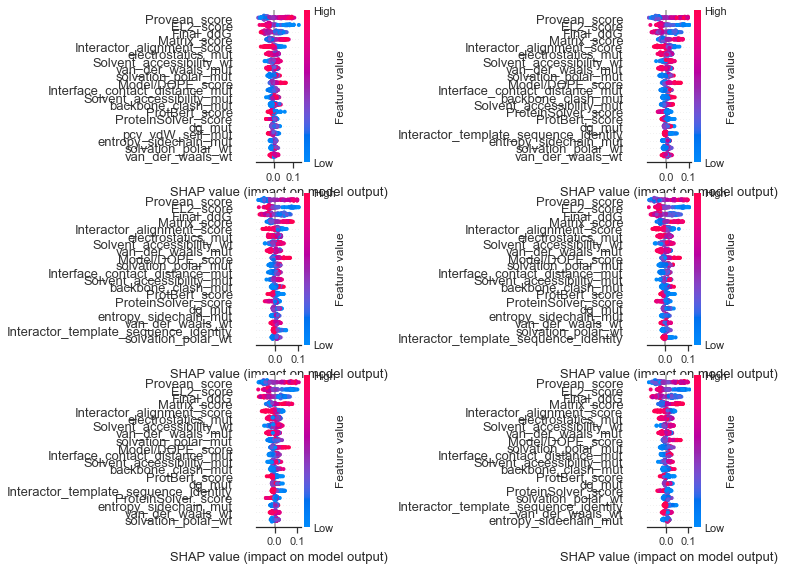

In [60]:
# explainer = shap.TreeExplainer(model)

# shap_values_0 = explainer.shap_values(Xs[0], approximate=False, check_additivity=False)
# shap_values_1 = explainer.shap_values(Xs[1], approximate=False, check_additivity=False)
# shap_values_2 = explainer.shap_values(Xs[2], approximate=False, check_additivity=False)
# shap_values_3 = explainer.shap_values(Xs[3], approximate=False, check_additivity=False)
# shap_values_4 = explainer.shap_values(Xs[4], approximate=False, check_additivity=False)
# shap_values_5 = explainer.shap_values(Xs[5], approximate=False, check_additivity=False)

# plt.figure(figsize=(20, 3))
# plt.subplots_adjust(wspace=6.0, hspace=0.2)
# plt.subplot(3,2,1)
# shap.summary_plot(shap_values_0[1], Xs[0], show=False)
# plt.subplot(3,2,2)
# shap.summary_plot(shap_values_1[1], Xs[1], show=False)
# plt.subplot(3,2,3)
# shap.summary_plot(shap_values_2[1], Xs[2], show=False)
# plt.subplot(3,2,4)
# shap.summary_plot(shap_values_3[1], Xs[3], show=False)
# plt.subplot(3,2,5)
# shap.summary_plot(shap_values_4[1], Xs[4], show=False)
# plt.subplot(3,2,6)
# shap.summary_plot(shap_values_5[1], Xs[5], show=False)
# # plt.tight_layout()
# plt.show()

In [58]:
def get_shap_top_n_features(shap_values, features, n=10):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    column_list = column_list[:n]

    return list(column_list)


In [59]:
# # Shap waterfall plot
# get_shap_top_n_features(shap_values[1], samples, num_display=11)

In [60]:
print(get_shap_top_n_features(shap_values_list[0][1], Xs[0], n=10))
print('* * *')
print(get_shap_top_n_features(shap_values_list[1][1], Xs[1], n=10))
print('* * *')
print(get_shap_top_n_features(shap_values_list[2][1], Xs[2], n=10))
print('* * *')
print(get_shap_top_n_features(shap_values_list[3][1], Xs[3], n=10))
print('* * *')
print(get_shap_top_n_features(shap_values_list[4][1], Xs[4], n=10))
print('* * *')
print(get_shap_top_n_features(shap_values_list[5][1], Xs[5], n=10))
print('* * *')

NameError: name 'shap_values_list' is not defined

In [61]:
Xs_train_shap = [None] * NUM_EXPERIMENT_REPEAT

# here, I selected top shap 10 for all. (i.e. n=10)
for i in range(len(Xs_train)):
    Xs_train_shap[i] = Xs_train[i][get_shap_top_n_features(shap_values_train_list[i][1], Xs_train[i], n=10)]

In [62]:
# Xs_train_shap_20 = [None] * NUM_EXPERIMENT_REPEAT

# # here, I selected top shap 20 for all. (i.e. n=20)
# for i in range(len(Xs_train)):
#     Xs_train_shap_20[i] = Xs_train[i][get_shap_top_n_features(shap_values_train_list[i][1], Xs_train[i], n=10)]

### Highly selected features by shap using 25 training sets

In [63]:
from collections import defaultdict

In [64]:
selected_features_to_occurrences = defaultdict(int)
for L in [list(data.columns) for data in Xs_train_shap]:
    for feature in L:
        selected_features_to_occurrences[feature] += 1

In [65]:
selected_features_to_occurrences

defaultdict(int,
            {'Provean_score': 50,
             'Final_ddG': 49,
             'EL2_score': 50,
             'Interactor_template_sequence_identity': 19,
             'Matrix_score': 34,
             'Interactor_alignment_score': 38,
             'Interface_contact_distance_wt': 10,
             'Solvent_accessibility_mut': 24,
             'Model/DOPE_score': 17,
             'Solvent_accessibility_wt': 32,
             'electrostatics_mut': 9,
             'van_der_waals_mut': 23,
             'pcv_vdW_self_wt': 11,
             'solvation_polar_wt': 8,
             'entropy_mainchain_wt': 15,
             'sidechain_hbond_mut': 3,
             'Interface_contact_distance_mut': 13,
             'entropy_sidechain_wt': 10,
             'entropy_sidechain_mut': 9,
             'pcv_vdW_wt': 4,
             'sidechain_hbond_wt': 2,
             'solvation_polar_mut': 13,
             'torsional_clash_mut': 2,
             'backbone_clash_mut': 3,
             'ProteinSolv

In [66]:
highly_selected_10_features = sorted(selected_features_to_occurrences, key=selected_features_to_occurrences.get, reverse=True)[:10]
highly_selected_10_features

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

In [66]:
Xs_shap = [None] * NUM_EXPERIMENT_REPEAT

# here, I selected top shap 10 for all. (i.e. n=10)
for i in range(len(Xs)):
    Xs_shap[i] = Xs[i][get_shap_top_n_features(shap_values_list[i][1], Xs[i], n=10)]

In [67]:
Xs_shap[5].head()

,Provean_score,Final_ddG,EL2_score,Matrix_score,Interface_contact_distance_wt,solvation_polar_mut,van_der_waals_mut,entropy_mainchain_wt,entropy_sidechain_wt,electrostatics_mut
0,-5.508,1.569280,2.187274,-2.0,3.51280,30.3491,-21.3295,6.46806,9.38136,-6.188740
1,-5.535,0.857536,1.978498,-1.0,5.63582,27.4449,-12.8082,2.78544,7.49495,-0.578504
2,-6.332,1.576110,2.260260,-4.0,3.36631,16.5146,-12.7494,4.64430,7.30724,-0.188091
3,-2.614,0.378951,2.295482,2.0,3.17587,23.4829,-18.4170,3.69911,10.87910,-2.487090
4,-7.825,2.372500,1.096801,-1.0,4.75817,16.8417,-11.2983,3.65390,5.84793,-0.037613


In [68]:
Xs_shap[3].columns

Index(['Provean_score', 'EL2_score', 'Interactor_alignment_score', 'Final_ddG',
       'Matrix_score', 'Solvent_accessibility_mut', 'van_der_waals_mut',
       'Interactor_template_sequence_identity', 'solvation_polar_mut',
       'ProtBert_score'],
      dtype='object')

In [69]:
Xs_shap[17].columns

Index(['Final_ddG', 'Provean_score', 'EL2_score', 'Interactor_alignment_score',
       'Solvent_accessibility_mut', 'Matrix_score', 'solvation_polar_mut',
       'Interface_hydrophilic_area', 'entropy_sidechain_mut',
       'solvation_polar_wt'],
      dtype='object')

In [70]:
Xs_shap[14].columns

Index(['Final_ddG', 'Provean_score', 'EL2_score', 'solvation_polar_wt',
       'Interactor_template_sequence_identity', 'Interactor_alignment_score',
       'van_der_waals_mut', 'entropy_sidechain_mut', 'entropy_sidechain_wt',
       'Solvent_accessibility_mut'],
      dtype='object')

## Feature Selection

**[TODO:]** For now, I am doing this process for only one training data, but the process will be applied to all.

In [101]:
Xs_0_Provean_score = Xs[0][['Provean_score']]
Xs_0_Final_ddG = Xs[0][['Final_ddG']]

Xs_1_Provean_score = Xs[1][['Provean_score']]
Xs_1_Final_ddG = Xs[1][['Final_ddG']]

In [102]:
X_0_benchmark_feature_names_dataframes =\
[("Xs_0_Provean_score", Xs_0_Provean_score),
 ("Xs_0_Final_ddG", Xs_0_Final_ddG),
 ("Xs_0_shap", Xs_shap[0]),
 ("Xs_0", Xs[0])
]

X_1_benchmark_feature_names_dataframes =\
[("Xs_1_Provean_score", Xs_1_Provean_score),
 ("Xs_1_Final_ddG", Xs_1_Final_ddG),
 ("Xs_1_shap", Xs_shap[1]),
 ("Xs_1", Xs[1])
]

In [58]:
X_0_benchmark_feature_names_dataframes_train =\
[
     ("Xs_train_shap_0", Xs_train_shap[0]),
     ("Xs_train_0", Xs_train[0])
]

In [360]:
Xs_benchmark_feature_names_dataframes_list = []
for run in range(NUM_EXPERIMENT_REPEAT):
    benchmark_feature_names_dataframes = [
         (f"Xs_train_{run}_shap", Xs_train_SHAP[run]),
         (f"Xs_train_{run}", Xs_train[run])
    ]
    Xs_benchmark_feature_names_dataframes_list.append(benchmark_feature_names_dataframes)

In [124]:
# TRAIN
Xs_train_benchmark_feature_names_dataframes_list = []
for run in range(NUM_EXPERIMENT_REPEAT):
    benchmark_feature_names_dataframes = [
         (f"Xs_train_{run}", Xs_train[run]),
         (f"Xs_train_{run}_shap_HSF_10", Xs_train[run][highly_selected_10_features]),
    ]
    Xs_train_benchmark_feature_names_dataframes_list.append(benchmark_feature_names_dataframes)

In [58]:
# TRAIN
Xs_train_benchmark_feature_names_dataframes_list = []
for run in range(NUM_EXPERIMENT_REPEAT):
    benchmark_feature_names_dataframes = [
         (f"Xs_train_{run}_shap_10", Xs_train_shap[run]),
         (f"Xs_train_{run}_shap_20", Xs_train_shap_20[run]),
         (f"Xs_train_{run}", Xs_train[run])
    ]
    Xs_train_benchmark_feature_names_dataframes_list.append(benchmark_feature_names_dataframes)

## Evaluation Metrics

In [68]:
from helpers.evaluation import evaluate_metrics

In [234]:
# let's first try with Xs_0
scoring_metrics = evaluate_metrics(X_0_benchmark_feature_names_dataframes, ys[0], RandomForestClassifier(random_state=42),
                                   n_repeats=10, n_jobs=4, verbose=True)


EVALUATION METRIC: F1
------------------------------------
Xs_0_Provean_score          : 0.526
Xs_0_Final_ddG              : 0.3966
Xs_0_shap                   : 0.6144
Xs_0                        : 0.5913

EVALUATION METRIC: BALANCED_ACCURACY
------------------------------------
Xs_0_Provean_score          : 0.6081
Xs_0_Final_ddG              : 0.5142
Xs_0_shap                   : 0.7028
Xs_0                        : 0.688

EVALUATION METRIC: ACCURACY
------------------------------------
Xs_0_Provean_score          : 0.6498
Xs_0_Final_ddG              : 0.5586
Xs_0_shap                   : 0.7429
Xs_0                        : 0.731

EVALUATION METRIC: F1_MACRO
------------------------------------
Xs_0_Provean_score          : 0.6214
Xs_0_Final_ddG              : 0.5142
Xs_0_shap                   : 0.7049
Xs_0                        : 0.6849

EVALUATION METRIC: F1_MICRO
------------------------------------
Xs_0_Provean_score          : 0.6481
Xs_0_Final_ddG              : 0.5653
Xs_0

In [60]:
# let's first try with Xs_0 TRAIN
scoring_metrics_train = evaluate_metrics(X_0_benchmark_feature_names_dataframes_train, ys_train[0], 
                                         RandomForestClassifier(random_state=42),
                                         n_repeats=10, n_jobs=4, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]


EVALUATION METRIC: F1
------------------------------------
Xs_train_shap_0             : 0.5844
Xs_train_0                  : 0.5539

EVALUATION METRIC: BALANCED_ACCURACY
------------------------------------
Xs_train_shap_0             : 0.7024
Xs_train_0                  : 0.6666

EVALUATION METRIC: ACCURACY
------------------------------------
Xs_train_shap_0             : 0.7353
Xs_train_0                  : 0.7045

EVALUATION METRIC: F1_MACRO
------------------------------------
Xs_train_shap_0             : 0.7015
Xs_train_0                  : 0.6662

EVALUATION METRIC: F1_MICRO
------------------------------------
Xs_train_shap_0             : 0.7443
Xs_train_0                  : 0.706

EVALUATION METRIC: PRECISION
------------------------------------
Xs_train_shap_0             : 0.7281
Xs_train_0                  : 0.6857

EVALUATION METRIC: RECALL
------------------------------------
Xs_train_shap_0             : 0.554
Xs_train_0                  : 0.502

EVALUATION METRIC: R

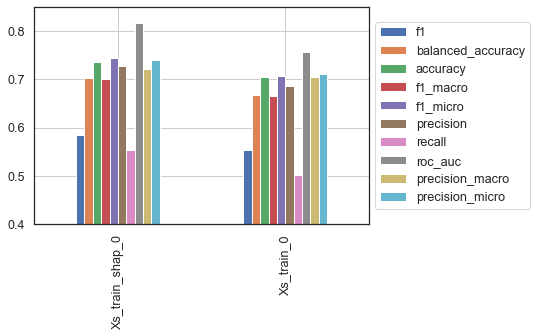

In [62]:
scoring_metrics_train.plot(kind='bar', grid=True, ylim=[0.40, 0.85]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

In [87]:
2

2

In [125]:
# [TRAIN] now will all, repeat is 10 
scoring_metrics_list = []
for run in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    scoring_metrics = evaluate_metrics(Xs_train_benchmark_feature_names_dataframes_list[run], ys_train[run], 
                                       RandomForestClassifier(random_state=42),
                                       n_repeats=10, n_jobs=-2, verbose=False)
    scoring_metrics_list.append(scoring_metrics)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [83]:
# now will all, repeat is 1 for now. TRAIN
scoring_metrics_list = []
for run in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    scoring_metrics = evaluate_metrics(Xs_train_benchmark_feature_names_dataframes_list[run], ys_train[run], 
                                       RandomForestClassifier(random_state=42),
                                       n_repeats=1, n_jobs=2, verbose=False)
    scoring_metrics_list.append(scoring_metrics)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
scoring_metrics

In [235]:
scoring_metrics.index.name = 'FEATURES'
scoring_metrics['Used_features'] = ['PROVEAN', 'FINAL_DDG', 'SHAP', 'ALL']
scoring_metrics

,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro,Used_features
FEATURES,,,,,,,,,,,
Xs_0_Provean_score,0.5260,0.6081,0.6498,0.6214,0.6481,0.5332,0.5376,0.6835,0.6163,0.6365,PROVEAN
Xs_0_Final_ddG,0.3966,0.5142,0.5586,0.5142,0.5653,0.4112,0.4133,0.5934,0.5233,0.5573,FINAL_DDG
Xs_0_shap,0.6144,0.7028,0.7429,0.7049,0.7374,0.7209,0.5714,0.7884,0.7325,0.7397,SHAP
Xs_0,0.5913,0.6880,0.7310,0.6849,0.7280,0.7348,0.5098,0.7655,0.7453,0.7329,ALL


In [238]:
# let's first try with Xs_1 
scoring_metrics_1 = evaluate_metrics(X_1_benchmark_feature_names_dataframes, ys[1], RandomForestClassifier(random_state=42),
                                     n_repeats=1, n_jobs=4, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]


EVALUATION METRIC: F1
------------------------------------
Xs_1_Provean_score          : 0.4863
Xs_1_Final_ddG              : 0.4506
Xs_1_shap                   : 0.6492
Xs_1                        : 0.5616

EVALUATION METRIC: BALANCED_ACCURACY
------------------------------------
Xs_1_Provean_score          : 0.6359
Xs_1_Final_ddG              : 0.6067
Xs_1_shap                   : 0.7459
Xs_1                        : 0.6798

EVALUATION METRIC: ACCURACY
------------------------------------
Xs_1_Provean_score          : 0.6522
Xs_1_Final_ddG              : 0.6346
Xs_1_shap                   : 0.7691
Xs_1                        : 0.7551

EVALUATION METRIC: F1_MACRO
------------------------------------
Xs_1_Provean_score          : 0.6052
Xs_1_Final_ddG              : 0.5721
Xs_1_shap                   : 0.7209
Xs_1                        : 0.6834

EVALUATION METRIC: F1_MICRO
------------------------------------
Xs_1_Provean_score          : 0.6346
Xs_1_Final_ddG              : 0.6151
X

In [236]:
scoring_metrics_dataframes = [scoring_metrics, scoring_metrics_1]

In [237]:
# concated_scoring_metrics = pd.concat([scoring_metrics, scoring_metrics_1], axis=0)
# concated_scoring_metrics

In [ ]:
# plt.figure(figsize=(8,5))
# sns.barplot(x='embark_town',y='fare',data=titanic, palette='rainbow', hue='class')
# plt.title("Fare of Passenger by Embarked Town, Divided by Class")

In [208]:
scoring_metrics_dataframes[i].index

Index(['Xs_0_Provean_score', 'Xs_0_Final_ddG', 'Xs_0_shap', 'Xs_0'], dtype='object', name='FEATURES')

In [375]:
scoring_metrics_list[0]

,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro
Xs_train_0_shap,0.5627,0.6813,0.7102,0.6366,0.6907,0.6633,0.50,0.7635,0.6995,0.7255
Xs_train_0,0.5606,0.6847,0.6981,0.6722,0.6951,0.6530,0.48,0.7216,0.7421,0.6909


In [65]:
scoring_metrics_list[0]

,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro
Xs_train_0_shap_10,0.5844,0.7000,0.7396,0.7007,0.7396,0.7365,0.548,0.8107,0.7494,0.7453
Xs_train_0_shap_20,0.6018,0.6972,0.7474,0.6955,0.7330,0.6921,0.542,0.8128,0.7160,0.7352
Xs_train_0,0.5579,0.6648,0.7176,0.6725,0.7112,0.6718,0.494,0.7588,0.7067,0.7023


In [66]:
scoring_metrics_list[4]

,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro
Xs_train_4_shap_10,0.5149,0.6471,0.6877,0.6345,0.7029,0.6497,0.4855,0.7453,0.6643,0.6947
Xs_train_4_shap_20,0.5185,0.6590,0.6888,0.6544,0.6902,0.6148,0.4300,0.7554,0.6946,0.6926
Xs_train_4,0.5004,0.6503,0.7058,0.6495,0.7092,0.7187,0.3800,0.7399,0.7031,0.7118


In [147]:
import matplotlib.patches as mpatches

In [70]:
def plot_comparison_single_experiment_2(num_rows, num_cols, i, dataframe):

#     plt.figure(figsize=(4, 3))
    
#     colors = ['#265191', '#9F2945', '#65d6ab', '#d9d900']
#     markers = ["+", ".", "^", "o"]
#     texts = ['F1', 'Balanced Accuracy', 'Accuracy', 'ROC']
#     patches = [ plt.plot([],[], marker=markers[i], ls="", color=colors[i], 
#                 label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]

  # additional colors ----> #ff5454, #32472a, #75a1ff
#     plt.ylim(0.50, 0.90)
    plt.subplot(num_rows, num_cols, i+1)
    dataframe.index.name = 'SELECTED_FEATURES'
    dataframe.reset_index().plot(
         x="SELECTED_FEATURES", y=["f1", "balanced_accuracy", "accuracy", "f1_macro"], kind="bar", subplots=True,
         figsize=(15, 5), color=['#265191', '#9F2945', '#65d6ab', '#d9d900']
    )
    plt.grid()
    
#     x = [0,1]
#     labels = list(dataframe.index)
#     plt.xticks(x, labels, rotation='vertical')
    
#     # plt.grid()
#     # plt.legend(handles=patches)
#     plt.xlabel("Selected Features")
#     plt.ylabel("Scores")|
# #     plt.show();

In [372]:
def plot_comparison_single_experiment(i, dataframe):

#     plt.figure(figsize=(4, 3))
    
    colors = ['#265191', '#9F2945', '#65d6ab', '#d9d900']
    markers = ["+", ".", "^", "o"]
    texts = ['F1', 'Balanced Accuracy', 'Accuracy', 'ROC']
    patches = [ plt.plot([],[], marker=markers[i], ls="", color=colors[i], 
                label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    
    for j in range(2):
        plt.plot(j, np.array(dataframe["f1"][j]), "+", color='#265191', alpha=1)
        plt.plot(j, np.array(dataframe["balanced_accuracy"][j]), ".", color='#9F2945', alpha=1)
        plt.plot(j, np.array(dataframe["accuracy"][j]), "^", color='#65d6ab', alpha=1)
        plt.plot(j, np.array(dataframe["roc_auc"][j]), "o", color='#d9d900', alpha=1)


#     plt.ylim(0.50, 0.90)
    
    x = [0,1]
    labels = list(dataframe.index)
    plt.xticks(x, labels, rotation='vertical')
    
    # plt.grid()
    # plt.legend(handles=patches)
    plt.xlabel("Selected Features")
    plt.ylabel("Scores")
#     plt.show();

In [71]:
plot_comparison_single_experiment_2(0, scoring_metrics_list[0])

TypeError: plot_comparison_single_experiment_2() missing 2 required positional arguments: 'i' and 'dataframe'

In [72]:
plot_comparison_single_experiment(1)

NameError: name 'plot_comparison_single_experiment' is not defined

In [73]:
Xs_train_shap[0].columns

Index(['Provean_score', 'EL2_score', 'Matrix_score', 'electrostatics_mut',
       'Final_ddG', 'Interactor_alignment_score', 'Solvent_accessibility_mut',
       'Model/DOPE_score', 'van_der_waals_mut', 'pcv_vdW_self_wt'],
      dtype='object')

In [74]:
Xs_train_shap[1].columns

Index(['EL2_score', 'Provean_score', 'Final_ddG', 'sidechain_hbond_mut',
       'Solvent_accessibility_wt', 'Matrix_score', 'entropy_sidechain_mut',
       'entropy_sidechain_wt', 'sidechain_hbond_wt',
       'Interactor_template_sequence_identity'],
      dtype='object')

In [261]:
pd.concat([
    (scoring_metrics_data[scoring_metrics_data['FEATURES'] == 'all']
     .groupby(by=['METRIC']).mean().drop(['EXPERIMENT_NO'], axis='columns')
     .rename(columns={'SCORE': 'All Columns'})),
    (scoring_metrics_data[scoring_metrics_data['FEATURES'] == 'shap']
     .groupby(by=['METRIC']).mean().drop(['EXPERIMENT_NO'], axis='columns')
     .rename(columns={'SCORE': 'SHAP Columns (10)'}))],
    axis='columns')

,All Columns,SHAP Columns (10)
METRIC,,
accuracy,0.715612,0.732914
balanced_accuracy,0.648094,0.680764
f1,0.481626,0.554030
f1_macro,0.641634,0.679988
f1_micro,0.714088,0.732578
precision,0.659892,0.688068
precision_macro,0.701772,0.723204
precision_micro,0.714304,0.734466
recall,0.415460,0.501420


In [195]:
scoring = scoring_metrics_list[0].copy()
scoring.index.name = 'X_NAME'
scoring.insert(0, 'FEATURES', ['all', 'shap'])
scoring.insert(0, 'EXPERIMENT_NO', 0)
scoring.reset_index(inplace=True)
scoring = scoring.melt(id_vars=["X_NAME", "FEATURES", "EXPERIMENT_NO"], 
                      var_name="METRIC", 
                      value_name="SCORE")
scoring

,X_NAME,FEATURES,EXPERIMENT_NO,METRIC,SCORE
0,Xs_train_0,all,0,f1,0.4862
1,Xs_train_0_shap_HSF_10,shap,0,f1,0.5770
2,Xs_train_0,all,0,balanced_accuracy,0.6648
3,Xs_train_0_shap_HSF_10,shap,0,balanced_accuracy,0.7022
4,Xs_train_0,all,0,accuracy,0.7414
5,Xs_train_0_shap_HSF_10,shap,0,accuracy,0.7580
6,Xs_train_0,all,0,f1_macro,0.6518
7,Xs_train_0_shap_HSF_10,shap,0,f1_macro,0.7148
8,Xs_train_0,all,0,f1_micro,0.7377
9,Xs_train_0_shap_HSF_10,shap,0,f1_micro,0.7564


In [188]:
scoring = scoring_metrics_list[0].copy()
scoring.index.name = 'X_NAME'
scoring.insert(0, 'FEATURES', ['all', 'shap'])
scoring['EXPERIMENT_NO'] = 0
scoring.reset_index(inplace=True)
scoring

,X_NAME,FEATURES,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro,EXPERIMENT_NO
0,Xs_train_0,all,0.4862,0.6648,0.7414,0.6518,0.7377,0.7413,0.395,0.7723,0.7302,0.7375,0
1,Xs_train_0_shap_HSF_10,shap,0.5770,0.7022,0.7580,0.7148,0.7564,0.7250,0.547,0.8101,0.7540,0.7593,0


In [196]:
scoring_metrics_entries = []
for i in range(NUM_EXPERIMENT_REPEAT):
    scoring = scoring_metrics_list[i].copy()
    scoring.index.name = 'X_NAME'
    scoring.insert(0, 'FEATURES', ['all', 'shap'])
    scoring.insert(0, 'EXPERIMENT_NO', i)
    scoring.reset_index(inplace=True)
    scoring = scoring.melt(id_vars=["X_NAME", "FEATURES", "EXPERIMENT_NO"], 
                          var_name="METRIC", 
                          value_name="SCORE")
    scoring_metrics_entries.append(scoring)

In [199]:
scoring_metrics_data = pd.concat(scoring_metrics_entries, axis='rows')
print(scoring_metrics_data.shape)
scoring_metrics_data.head()

(1000, 5)


,X_NAME,FEATURES,EXPERIMENT_NO,METRIC,SCORE
0,Xs_train_0,all,0,f1,0.4862
1,Xs_train_0_shap_HSF_10,shap,0,f1,0.5770
2,Xs_train_0,all,0,balanced_accuracy,0.6648
3,Xs_train_0_shap_HSF_10,shap,0,balanced_accuracy,0.7022
4,Xs_train_0,all,0,accuracy,0.7414


In [200]:
import seaborn as sns

In [ ]:
sns.set_theme(style="ticks", palette="pastel")

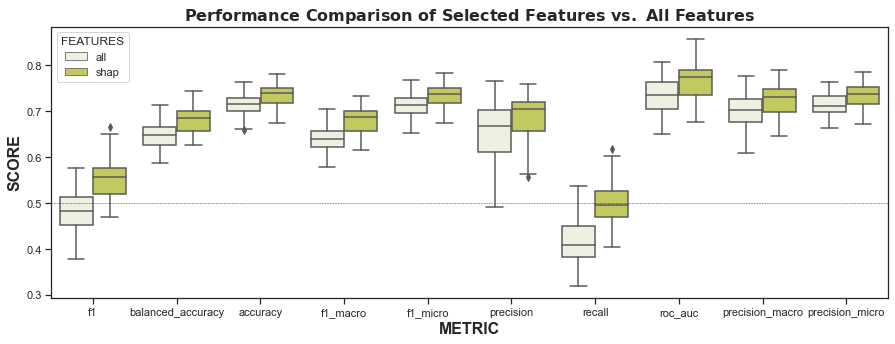

In [236]:
plt.figure(figsize=(15, 5))
plt.title(r'$\mathbf{Performance\ Comparison\ of\ Selected\ Features\ vs.\ All\ Features}$', fontsize=16, fontweight='bold')
plt.ylabel('Metrics', fontsize=16, fontweight='bold')
plt.xlabel('Scores', fontsize=16, fontweight='bold')
plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.8, lw=0.5)
sns.boxplot(x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data, palette='light:#d2db4f')
# plt.grid()
plt.show()
# sns.despine(offset=10, trim=True)

In [ ]:
# light:#03012d

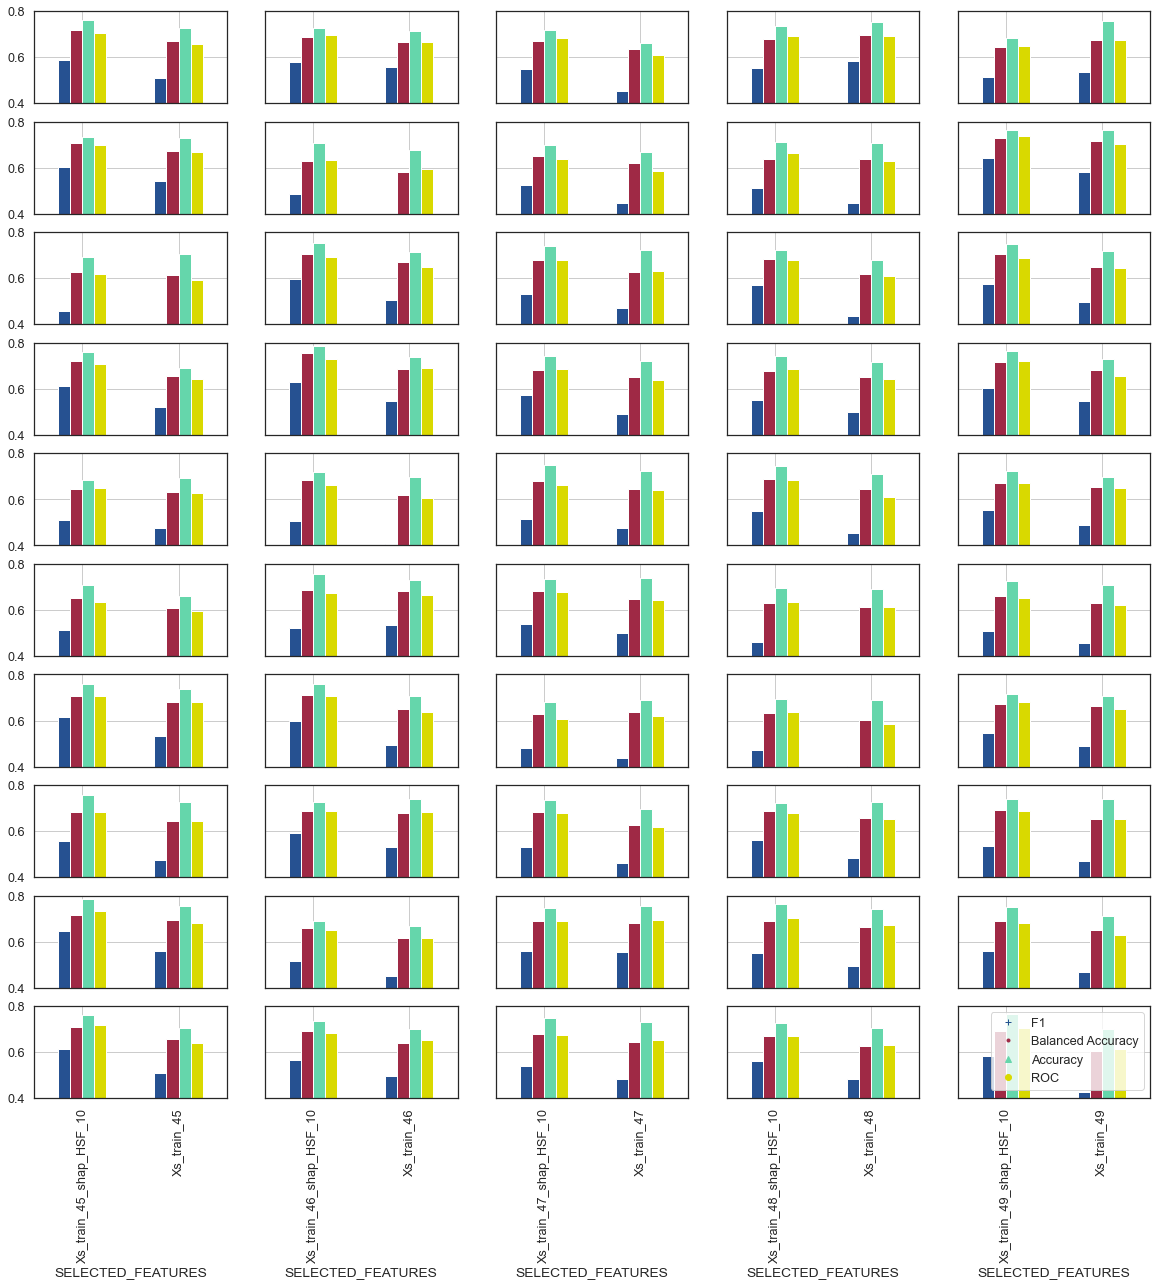

In [123]:
#define number of rows and columns for subplots
nrow=10
ncol=5

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20))

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        data = scoring_metrics_list[count].copy()
        data.index.name = 'SELECTED_FEATURES'
        data.reset_index().plot(
            ax=axes[r,c], x="SELECTED_FEATURES", y=["f1", "balanced_accuracy", "accuracy", "f1_macro"], kind="bar",
            color=['#265191', '#9F2945', '#65d6ab', '#d9d900'], sharey=True, sharex=True, ylim=[0.40, 0.80], legend=False, grid=True
        )
        count+=1
        
colors = ['#265191', '#9F2945', '#65d6ab', '#d9d900']
markers = ["+", ".", "^", "o"]
texts = ['F1', 'Balanced Accuracy', 'Accuracy', 'ROC']
patches = [ plt.plot([],[], marker=markers[i], ls="", color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]

plt.legend(handles=patches);

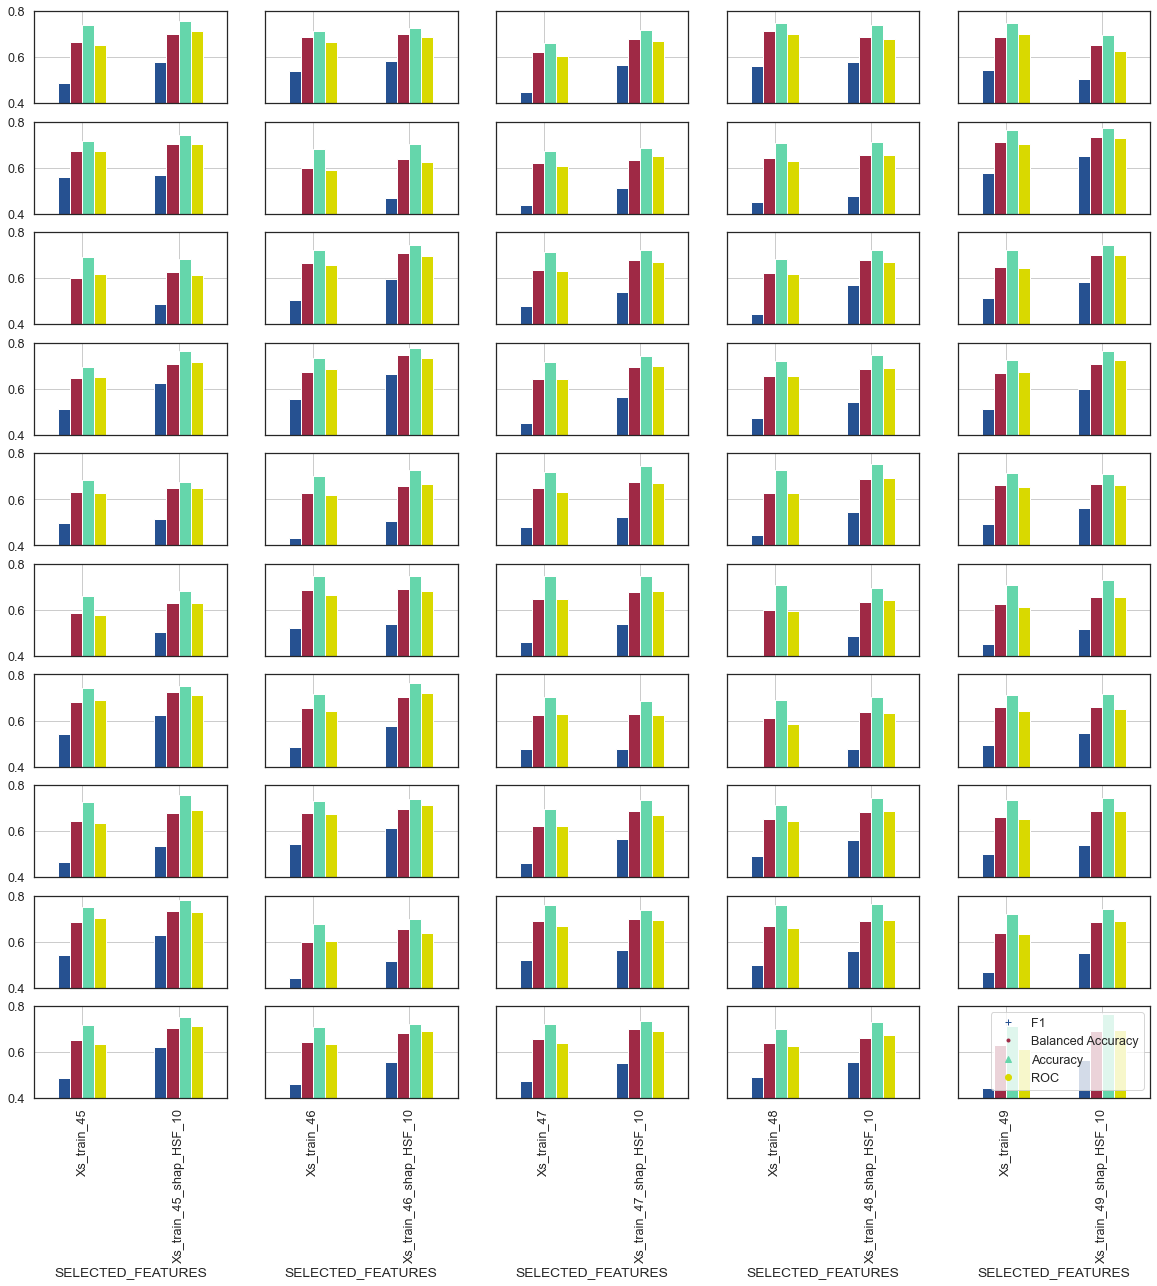

In [126]:
#define number of rows and columns for subplots
nrow=10
ncol=5

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20))

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        data = scoring_metrics_list[count].copy()
        data.index.name = 'SELECTED_FEATURES'
        data.reset_index().plot(
            ax=axes[r,c], x="SELECTED_FEATURES", y=["f1", "balanced_accuracy", "accuracy", "f1_macro"], kind="bar",
            color=['#265191', '#9F2945', '#65d6ab', '#d9d900'], sharey=True, sharex=True, ylim=[0.40, 0.80], legend=False, grid=True
        )
        count+=1
        
colors = ['#265191', '#9F2945', '#65d6ab', '#d9d900']
markers = ["+", ".", "^", "o"]
texts = ['F1', 'Balanced Accuracy', 'Accuracy', 'ROC']
patches = [ plt.plot([],[], marker=markers[i], ls="", color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]

plt.legend(handles=patches);

  0%|          | 0/25 [00:00<?, ?it/s]

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


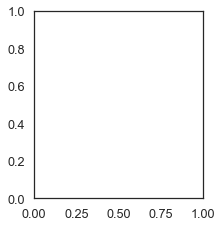

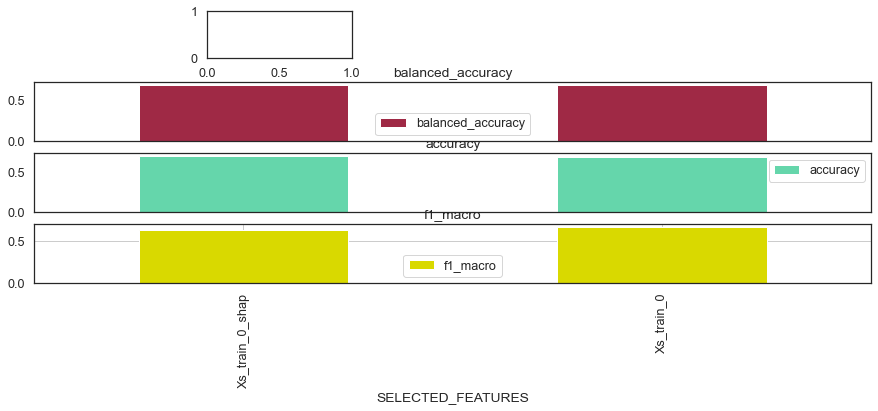

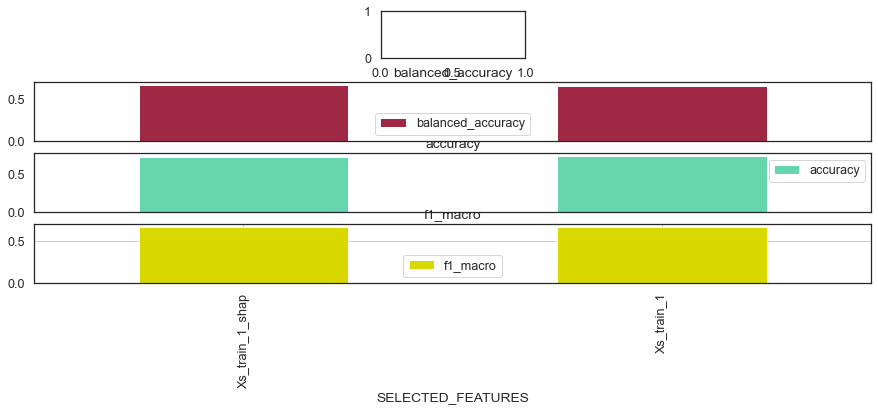

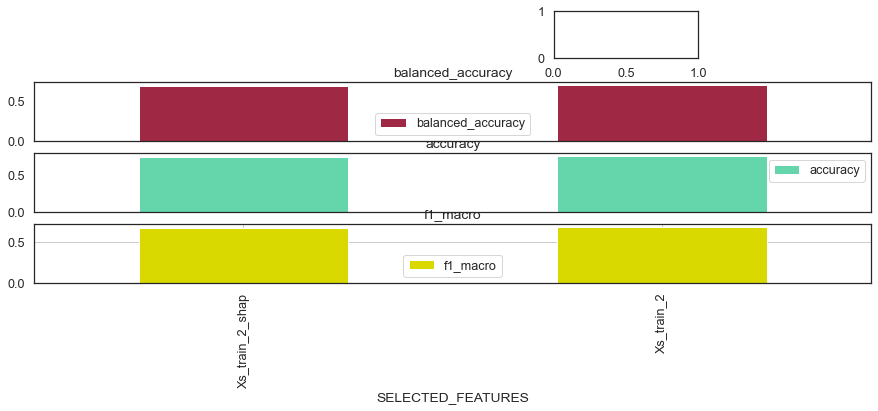

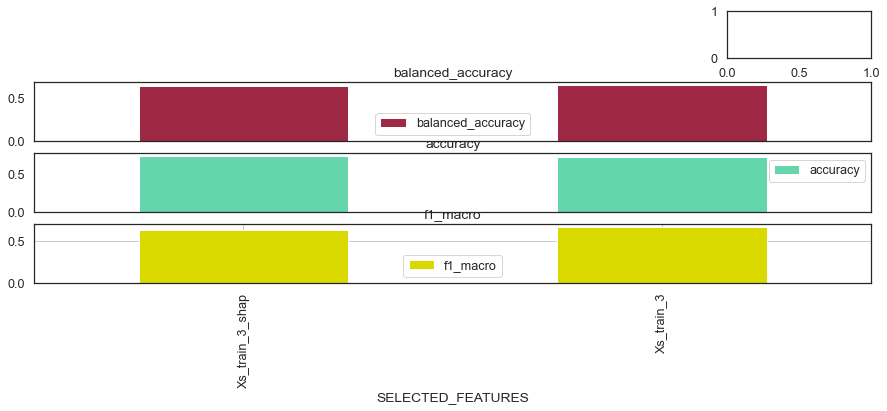

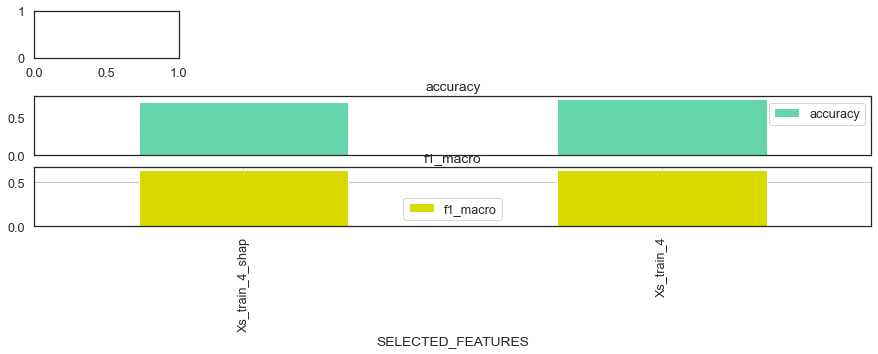

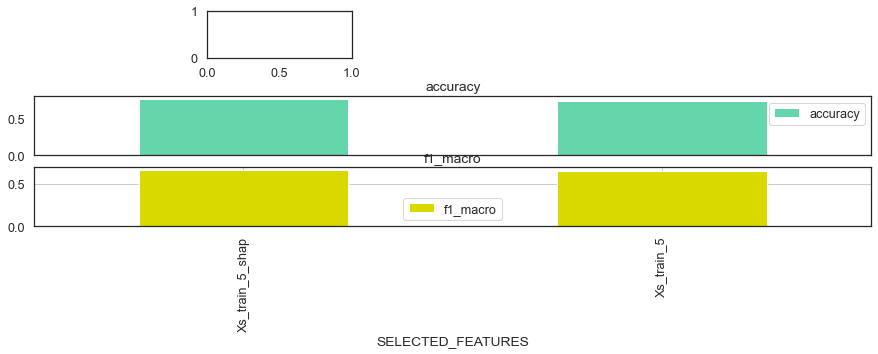

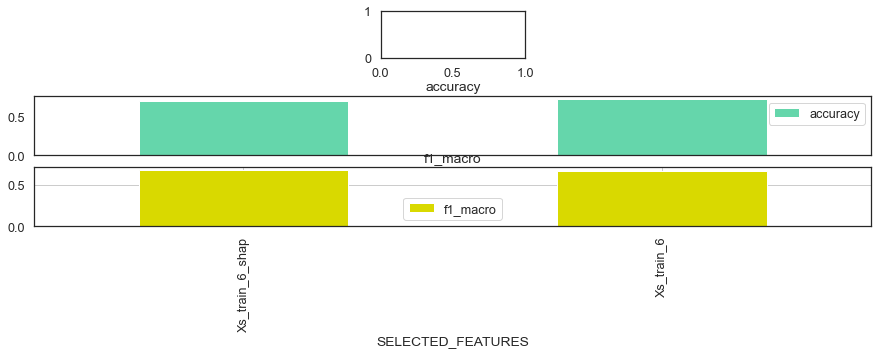

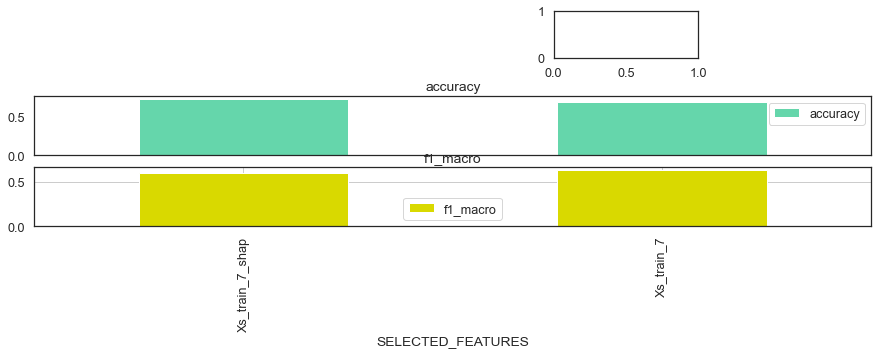

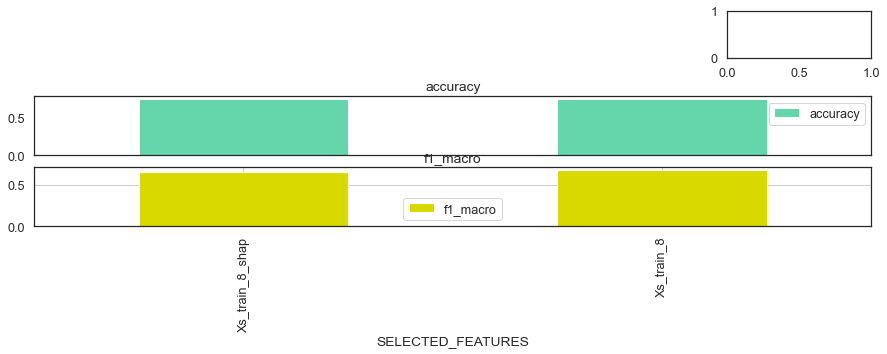

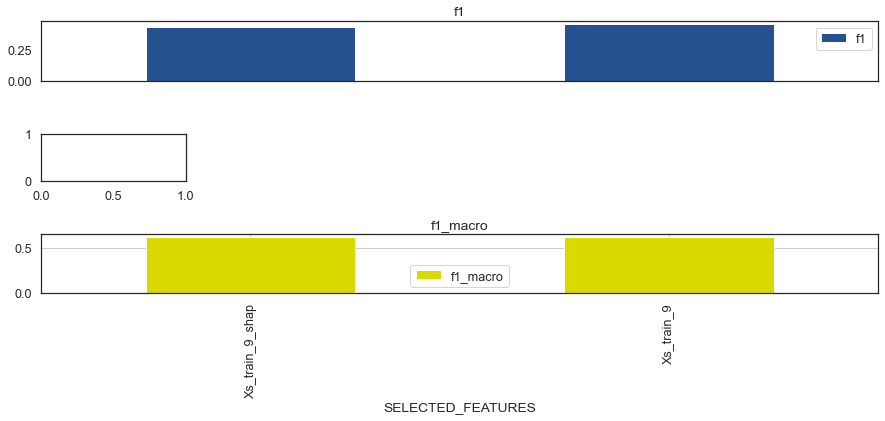

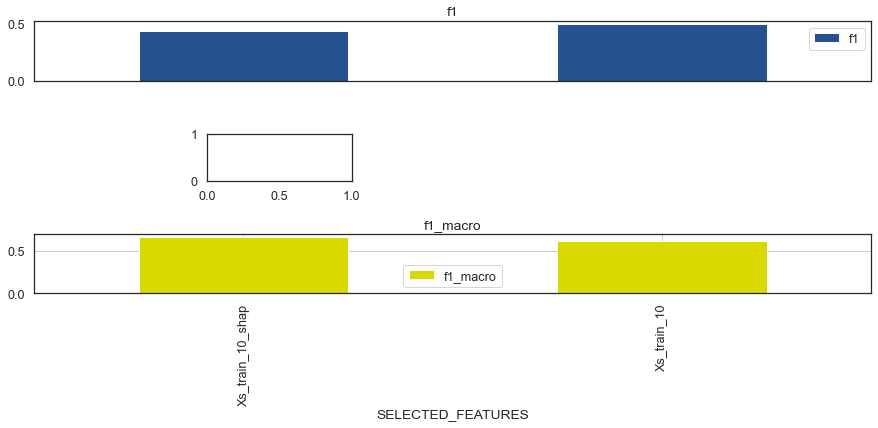

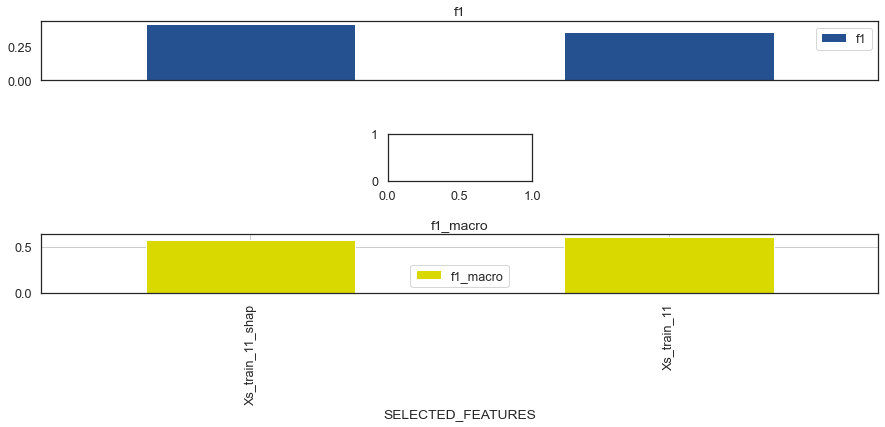

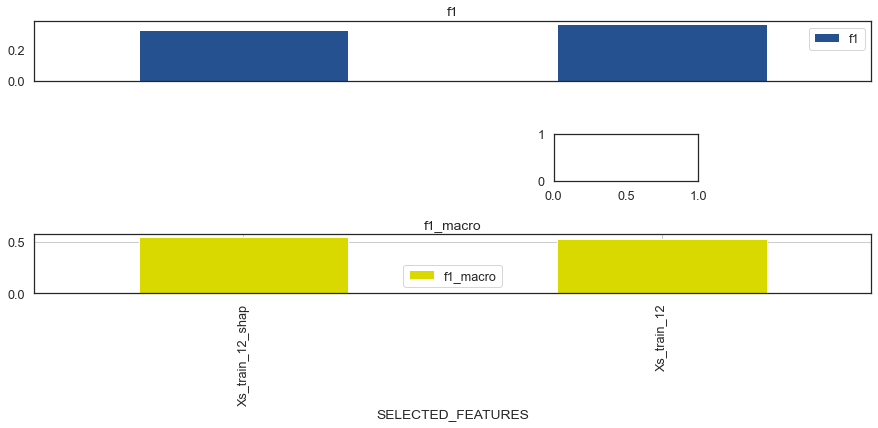

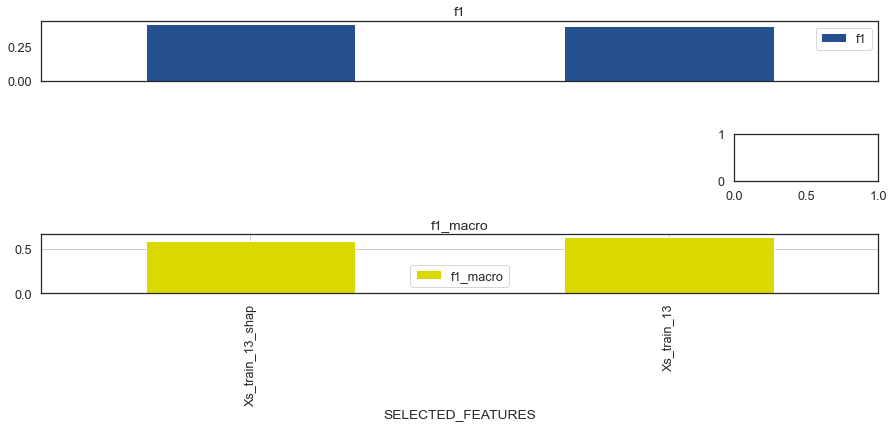

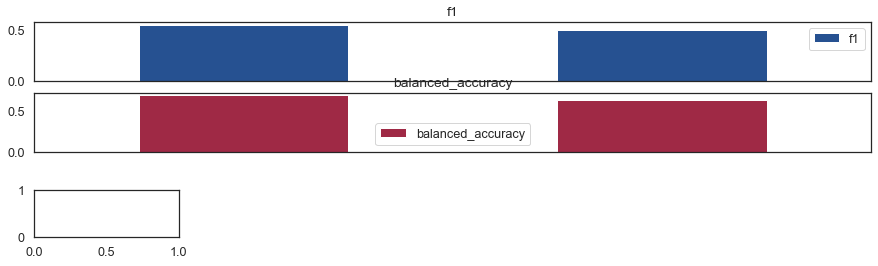

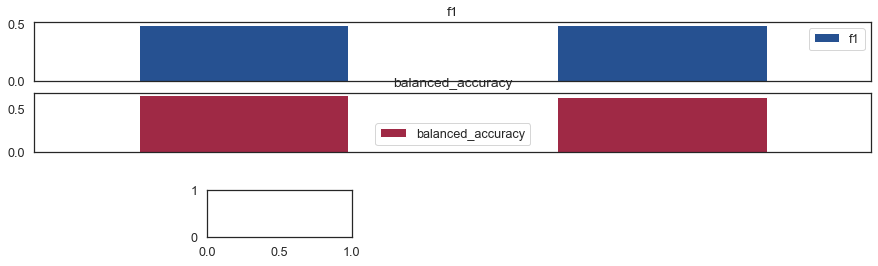

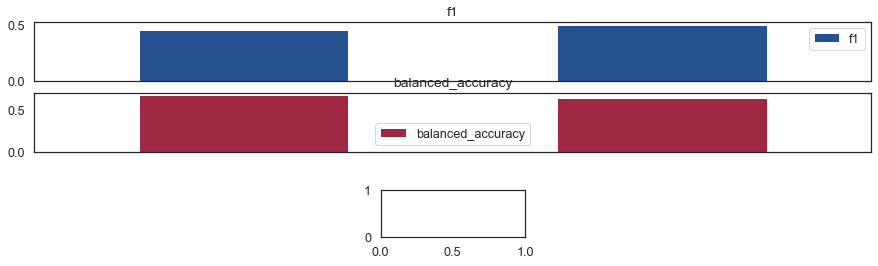

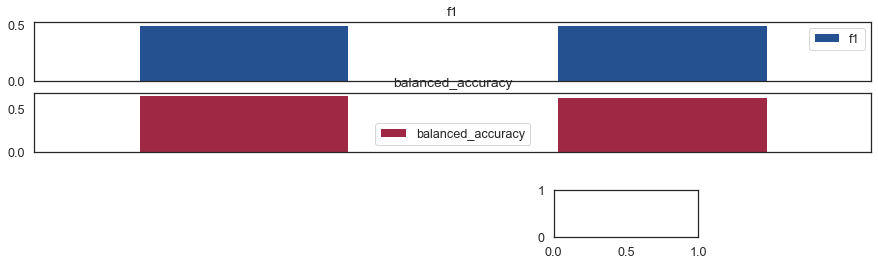

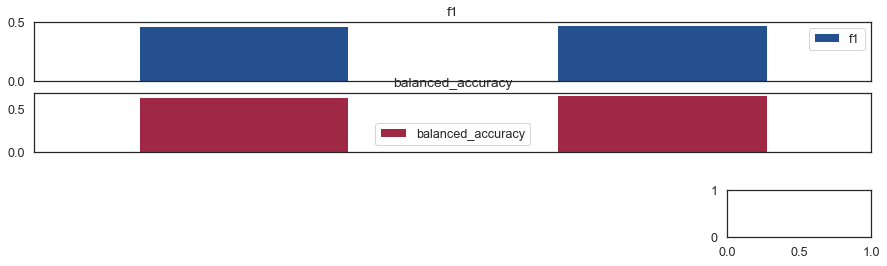

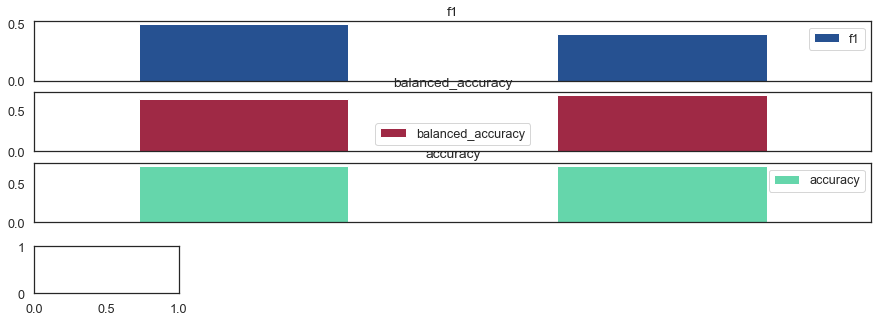

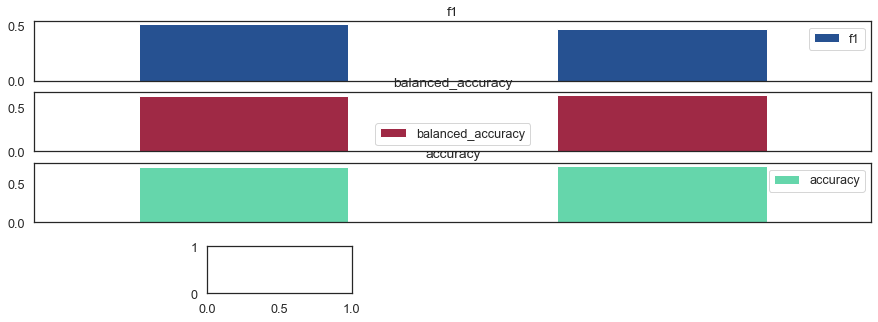

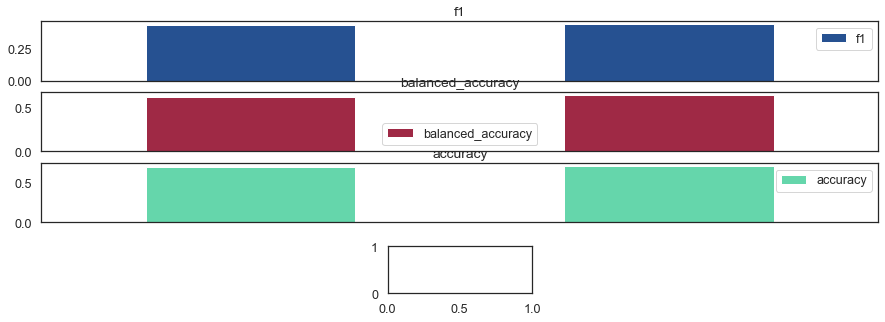

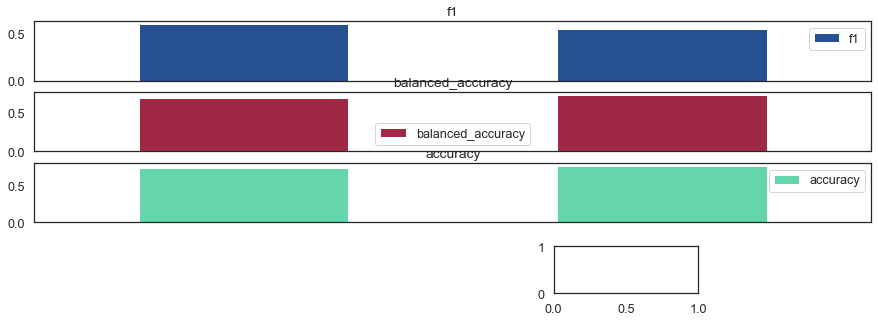

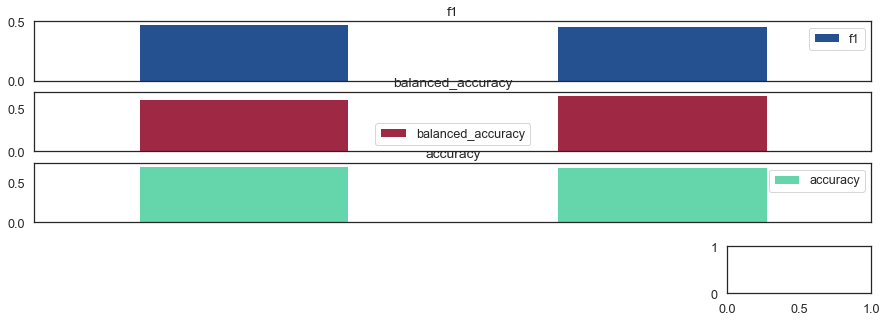

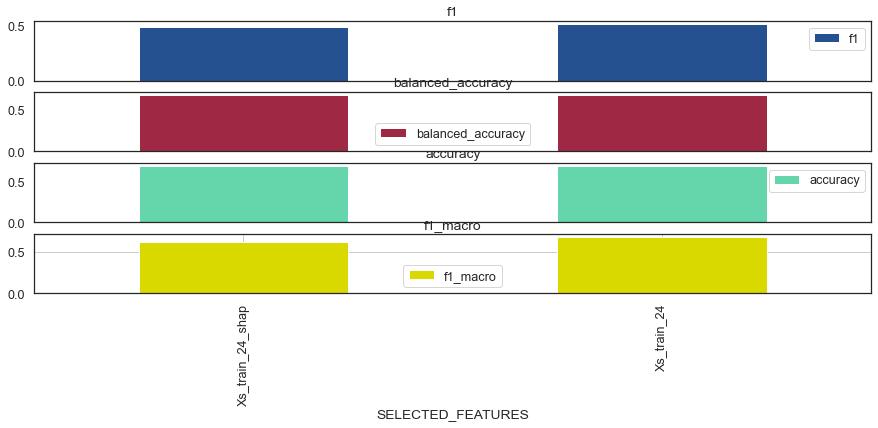

In [398]:
num_rows, num_cols = 5, 5

plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0.4, hspace=0.2)
for run in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    plot_comparison_single_experiment_2(num_rows, num_cols, run, scoring_metrics_list[run])


In [294]:
plt.close()

In [357]:
scoring_metrics_list[0]

,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro
Xs_valid_0_shap,0.2260,0.5633,0.6267,0.5017,0.6617,0.2867,0.34,0.5733,0.4817,0.6033
Xs_valid_0,0.3067,0.5533,0.6217,0.5016,0.6150,0.2667,0.31,0.5950,0.4408,0.6150


In [358]:
scoring_metrics_list[1]

,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro
Xs_valid_1_shap,0.1000,0.4533,0.5883,0.4190,0.550,0.0733,0.12,0.4908,0.3792,0.6067
Xs_valid_1,0.1067,0.5217,0.5867,0.4577,0.585,0.1000,0.11,0.4992,0.4108,0.5900


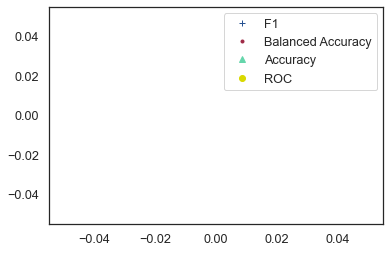

In [164]:
colors = ["#265191", '#9F2945', '#65d6ab', '#d9d900']
markers = ['+', '.', '^', 'o']
texts = ["F1", "Balanced Accuracy", 'Accuracy', 'ROC']
# patches = [ plt.plot([],[], marker=markers[i], ms=10, ls="", mec=None, color=colors[i], 
#             label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
patches = [ plt.plot([],[], marker=markers[i], ls="", color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
# plt.legend(handles=patches, loc='center', ncol=4, numpoints=1)
plt.legend(handles=patches)

plt.show()

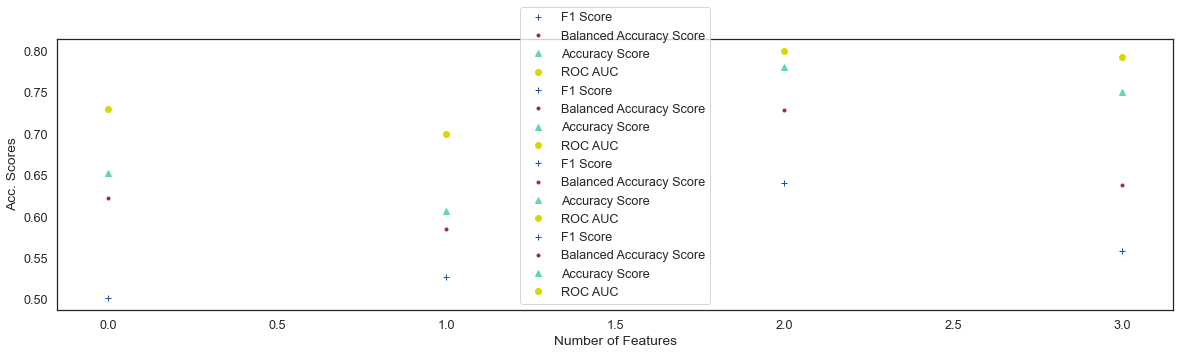

In [131]:
# Plotting balanced accuracy and accuracy scores
plt.figure(figsize=(20, 5))
# Adding individual cv scores for each n_features (using either "+" or ".")
for i in range(1):
    for j in range(4):
        plt.plot(i + j, np.array(scoring_metrics_1["f1"][j]), "+", color='#265191', alpha=1, label='F1 Score')
        plt.plot(i + j, np.array(scoring_metrics_1["balanced_accuracy"][j]), ".", color='#9F2945', alpha=1, label='Balanced Accuracy Score')
        plt.plot(i + j, np.array(scoring_metrics_1["accuracy"][j]), "^", color='#65d6ab', alpha=1, label='Accuracy Score')
        plt.plot(i + j, np.array(scoring_metrics_1["roc_auc"][j]), "o", color='#d9d900', alpha=1, label='ROC AUC')
# plt.ylim(0.80, 1)
plt.legend()
plt.xlabel("Number of Features")
plt.ylabel("Acc. Scores")
plt.show();


<AxesSubplot:>

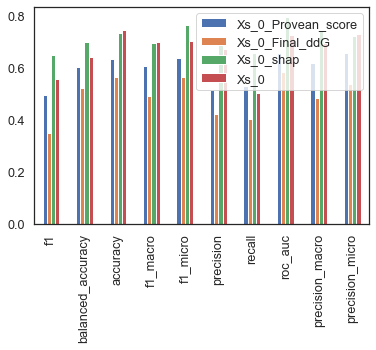

In [100]:
scoring_metrics.T.plot(kind='bar')

In [83]:
scoring_metrics

{'f1': [0.5204, 0.3553, 0.6185, 0.5733],
 'balanced_accuracy': [0.6208, 0.4951, 0.7232, 0.6528],
 'accuracy': [0.6529, 0.5599, 0.7504, 0.7202],
 'f1_macro': [0.625, 0.5418, 0.7217, 0.703],
 'f1_micro': [0.6268, 0.5482, 0.7449, 0.7246],
 'precision': [0.4837, 0.449, 0.7392, 0.7214],
 'recall': [0.5643, 0.381, 0.5333, 0.481],
 'roc_auc': [0.6669, 0.5788, 0.7686, 0.7659],
 'precision_macro': [0.6191, 0.4769, 0.7411, 0.7483],
 'precision_micro': [0.6452, 0.5548, 0.7577, 0.7136]}

In [82]:
pd.DataFrame(scoring_metrics)

,f1,balanced_accuracy,accuracy,f1_macro,f1_micro,precision,recall,roc_auc,precision_macro,precision_micro
0,0.5204,0.6208,0.6529,0.6250,0.6268,0.4837,0.5643,0.6669,0.6191,0.6452
1,0.3553,0.4951,0.5599,0.5418,0.5482,0.4490,0.3810,0.5788,0.4769,0.5548
2,0.6185,0.7232,0.7504,0.7217,0.7449,0.7392,0.5333,0.7686,0.7411,0.7577
3,0.5733,0.6528,0.7202,0.7030,0.7246,0.7214,0.4810,0.7659,0.7483,0.7136


In [ ]:
# TODO: IMPLEMENT CV MCC -- NEED TO USE CROSS VAL PREDICT
# Also, why it gives different results every time I run it?

In [78]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import matthews_corrcoef

def mcc_v2(X_param, y_param, clf):
    cv, n_jobs = cross_validation_options('skf_10', -1)
    y_pred = cross_val_predict(clf, X_param, y_param, cv=cv, n_jobs=-1)
    return matthews_corrcoef(y_param, y_pred)

In [79]:
mcc_v2(Xs[0], ys[0], RandomForestClassifier(random_state=42))

0.4369423249271076

In [84]:
mcc_v2(Xs[0], ys[0], RandomForestClassifier(random_state=42))

0.3929443676757604

In [111]:
mcc_v2(Xs_shap[0], ys[0], RandomForestClassifier(random_state=42))

0.5085318225147085

In [80]:
mcc_v2(Xs_shap[0], ys[0], RandomForestClassifier(random_state=42))

0.49564555774192176

In [113]:
mcc_v2(Xs_0_Provean_score, ys[0], RandomForestClassifier(random_state=42))

0.23203471479192908

In [81]:
mcc_v2(Xs_0_Provean_score, ys[0], RandomForestClassifier(random_state=42))

0.21663959583810308

# Fine Tuning

**[question]** Should I do Fine Tuning on 80% of data (training *set*) or all training data? **◄◄◄◄◄◄◄◄◄**

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [77]:
len(Xs_train[0]), len(ys_train[0])

(131, 131)

In [78]:
len(Xs_valid[0]), len(ys_valid[0])

(33, 33)

In [81]:
Xs_train_shap = []
Xs_valid_shap = []

for i in range(NUM_EXPERIMENT_REPEAT):
    Xs_train_shap.append(Xs_train[i][highly_selected_10_features])
    Xs_valid_shap.append(Xs_valid[i][highly_selected_10_features])

In [82]:
Xs_train_shap[0].columns

Index(['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score',
       'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut',
       'van_der_waals_mut', 'Interactor_template_sequence_identity',
       'Model/DOPE_score'],
      dtype='object')

In [83]:
all(Xs_train_shap[17].columns == Xs_shap[17].columns)

NameError: name 'Xs_shap' is not defined

In [89]:
# def plot_top_feature_importances_final(feature_importances, attributes_param, top_n=10, figsize=None):
#     feature_imp_series = pd.Series(feature_importances,
#                                    index = attributes_param).sort_values(ascending=False)
    
#     figsize = (5 , top_n//3) if not figsize else (5, 5)
    
#     sns.set(style="white", font_scale=1.15)  # white, dark, whitegrid, darkgrid, ticks
#     feature_imp_series_top_n = feature_imp_series[:top_n]
#     plt.figure(figsize=figsize)
#     sns.barplot(x=feature_imp_series_top_n, y=feature_imp_series_top_n.index, palette="ch:s=-.2,r=.6")
#     plt.xlabel('Feature Importance Scores')
#     plt.ylabel('Variables')
#     plt.title('Feature Importances (top {})'.format(top_n))
#     plt.show()

In [84]:
# param_grid_randomized  = {'bootstrap': [True, False],
#                           'max_depth': [2, 3, 4, 5, 7, 10, 20, 50],
#                           'max_features': ['auto', 'sqrt'],
#                           'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


# Let's try something quick, (don't want to wait for all 25 estimators just for testing.)
param_grid_randomized  = {'bootstrap': [True, False],
                          'max_depth': [2, 7, 12],
                          'max_features': ['auto', 'sqrt'],
                          'n_estimators': [200, 600, 1000, 1400, 1800]}

forest_clf = RandomForestClassifier(random_state=42)

randomized_search = RandomizedSearchCV(forest_clf, param_grid_randomized, n_iter=1,  ## TODO, change n_iter to 10, (or some other num.)
                                       random_state=42,    
                                       cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42), 
                                       scoring='balanced_accuracy', 
                                       return_train_score=True, n_jobs=-1, verbose=2)

In [85]:
def get_randomized_search(random_seed):
    param_grid_randomized  = {'bootstrap': [True, False],
                          'max_depth': [2, 7, 12],
                          'max_features': ['auto', 'sqrt'],
                          'n_estimators': [200, 600, 1000, 1400, 1800]}

    forest_clf = RandomForestClassifier(random_state=42)

    randomized_search = RandomizedSearchCV(forest_clf, param_grid_randomized, n_iter=1,  ## TODO, change n_iter to 10, (or some other num.)
                                           random_state=random_seed,    
                                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=random_seed), 
                                           scoring='balanced_accuracy', 
                                           return_train_score=True, n_jobs=-1, verbose=0)
    
    return randomized_search

In [88]:
randomized_search_objects = []
for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    randomized_search = get_randomized_search(np.random.randint(99999))
    randomized_search_objects.append(randomized_search.fit(Xs_train_shap[i], ys_train[i]))

  0%|          | 0/50 [00:00<?, ?it/s]

In [90]:
experiment_repeat_to_randomized_search_info = {}

for i in range(NUM_EXPERIMENT_REPEAT):
    experiment_repeat_to_randomized_search_info[F'EXP_RUN_{i+1}'] = [randomized_search_objects[i].best_params_,
                                                                     randomized_search_objects[i].best_estimator_,
                                                                     randomized_search_objects[i].best_score_]
    
classifiers_attributes_data = pd.DataFrame(experiment_repeat_to_randomized_search_info, 
                                           index=['best_params_', 'best_estimator_', 'best_score_']).T

classifiers_attributes_data.to_csv('classifiers_attributes_data_1.csv')
classifiers_attributes_data

,best_params_,best_estimator_,best_score_
EXP_RUN_1,"{'n_estimators': 1400, 'max_features': 'sqrt',...","(DecisionTreeClassifier(max_depth=2, max_featu...",0.683889
EXP_RUN_2,"{'n_estimators': 1400, 'max_features': 'sqrt',...","(DecisionTreeClassifier(max_depth=12, max_feat...",0.6875
EXP_RUN_3,"{'n_estimators': 1000, 'max_features': 'sqrt',...","(DecisionTreeClassifier(max_depth=12, max_feat...",0.672778
EXP_RUN_4,"{'n_estimators': 1000, 'max_features': 'sqrt',...","(DecisionTreeClassifier(max_depth=7, max_featu...",0.670417
EXP_RUN_5,"{'n_estimators': 1800, 'max_features': 'sqrt',...","(DecisionTreeClassifier(max_depth=12, max_feat...",0.690694
EXP_RUN_6,"{'n_estimators': 1000, 'max_features': 'auto',...","(DecisionTreeClassifier(max_depth=12, max_feat...",0.67625
EXP_RUN_7,"{'n_estimators': 200, 'max_features': 'auto', ...","(DecisionTreeClassifier(max_depth=12, max_feat...",0.646667
EXP_RUN_8,"{'n_estimators': 1800, 'max_features': 'sqrt',...","(DecisionTreeClassifier(max_depth=12, max_feat...",0.642917
EXP_RUN_9,"{'n_estimators': 1400, 'max_features': 'auto',...","(DecisionTreeClassifier(max_depth=2, max_featu...",0.689444
EXP_RUN_10,"{'n_estimators': 600, 'max_features': 'auto', ...","(DecisionTreeClassifier(max_depth=12, max_feat...",0.741667


In [91]:
final_models = []
for search_obj in randomized_search_objects:
    final_models.append(search_obj.best_estimator_)

# Final Evalution -- will come back to this later..

**Default Model with `X_train`**

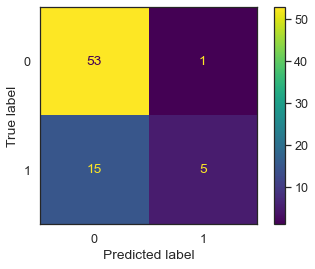

Balanced accuracy score : 0.6157
Accuracy score		: 0.7838


In [93]:
# Final scoring comparison: X_train, y_train with prediction of X_valid
forest_clf = RandomForestClassifier(random_state=42)

forest_clf.fit(X_train, y_train)

forest_predictions = forest_clf.predict(X_valid)

plot_confusion_matrix(forest_clf, X_valid, y_valid)
plt.show()

print("Balanced accuracy score : {:.4f}".format(balanced_accuracy_score(y_valid, forest_predictions)))
print("Accuracy score\t\t: {:.4f}".format(accuracy_score(y_valid, forest_predictions)))

**Default Model with `X_train_shap_top_11`**

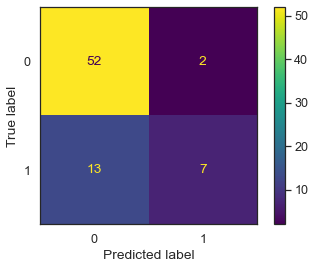

Balanced accuracy score : 0.6565
Accuracy score		: 0.7973


In [94]:
# Final scoring comparison: X_train_shap_top_11, y_train with prediction of X_valid_shap_top_11
forest_clf = RandomForestClassifier(random_state=42)

forest_clf.fit(X_train_shap_top_11, y_train)

forest_predictions = forest_clf.predict(X_valid_shap_top_11)

plot_confusion_matrix(forest_clf, X_valid_shap_top_11, y_valid)
plt.show()

print("Balanced accuracy score : {:.4f}".format(balanced_accuracy_score(y_valid, forest_predictions)))
print("Accuracy score\t\t: {:.4f}".format(accuracy_score(y_valid, forest_predictions)))

**Hyper-param Tuned Model with `X_train_shap_top_11`**

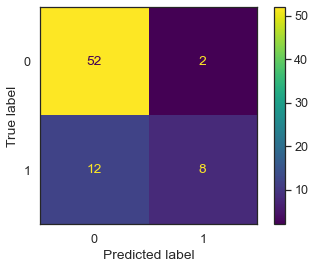

Balanced accuracy score : 0.6815
Accuracy score		: 0.8108


In [95]:
# Final scoring comparison: X_train_shap_top_11, y_train with prediction of X_valid_shap_top_11
forest_clf = randomized_search.best_estimator_

forest_clf.fit(X_train_shap_top_11, y_train)

forest_predictions = forest_clf.predict(X_valid_shap_top_11)

plot_confusion_matrix(forest_clf, X_valid_shap_top_11, y_valid)
plt.show()

print("Balanced accuracy score : {:.4f}".format(balanced_accuracy_score(y_valid, forest_predictions)))
print("Accuracy score\t\t: {:.4f}".format(accuracy_score(y_valid, forest_predictions)))

In [96]:
def evaluate_cross_val_avg_via(model_param, X_train_param, y_train_param,
                               plot_param=True, repeation_param=3):
    
    # Options for cross-validation cv= parameter.
    cv_option, n_jobs = cross_validation_options("skf_10", -1)
    repeation=repeation_param
    
    forest_scores_bas, forest_scores_as = [], []
    
    for i in range(repeation):
        
        # Cross-validation Accuracy and Balanced Accuracy Scores
        forest_scores_bas.append(cross_val_score(model_param, 
                                            X_train_param, y_train_param,
                                            cv=cv_option, 
                                            scoring="balanced_accuracy", n_jobs=n_jobs))

        forest_scores_as.append(cross_val_score(model_param, 
                                           X_train_param, y_train_param,
                                           cv=cv_option, 
                                           scoring="accuracy", n_jobs=n_jobs))

        # # Print scores and averages
        # print("Balanced accuracy score AVG : {:.4f}".format(forest_scores_bas[i].mean()))
        # print("Accuracy score AVG          : {:.4f}".format(forest_scores_as[i].mean()))
        
    if plot_param:
        plt.plot(range(1, len(forest_scores_as) + 1), np.array(forest_scores_as).mean(axis=1), "+", color='#265191', alpha=0.5, label="Accuracy_Scores")
        plt.plot(range(1, len(forest_scores_bas) + 1), np.array(forest_scores_bas).mean(axis=1), ".", color='#9F2945', alpha=0.5, label="Balanced_Accuracy_Scores")

        plt.ylim(0.50, 1)
        plt.xticks(range(1, repeation_param + 1))
        plt.legend()
        plt.xlabel("Repetitions")
        plt.ylabel("Scores AVG")
        plt.title("Accuracy and Balanced Accuracy AVG Scores per Repetition")
        plt.show();

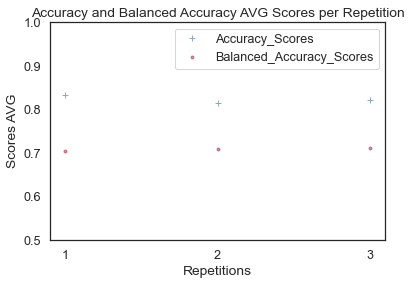

In [97]:
evaluate_cross_val_avg_via(randomized_search.best_estimator_, X, y)

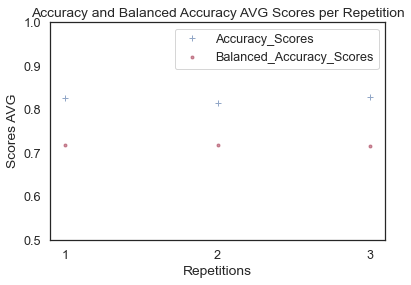

In [98]:
evaluate_cross_val_avg_via(randomized_search.best_estimator_, X_shap_top_6, y)

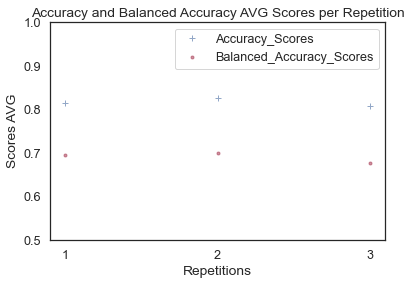

In [99]:
evaluate_cross_val_avg_via(randomized_search.best_estimator_, X_shap_top_11, y)

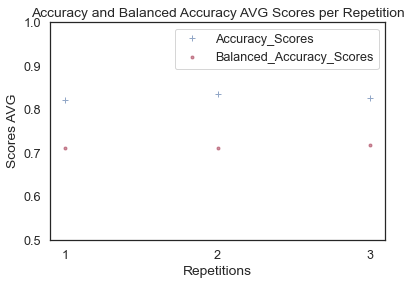

In [100]:
evaluate_cross_val_avg_via(RandomForestClassifier(), X, y)

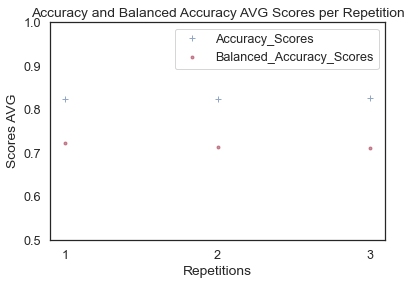

In [101]:
evaluate_cross_val_avg_via(RandomForestClassifier(), X_shap_top_6, y)

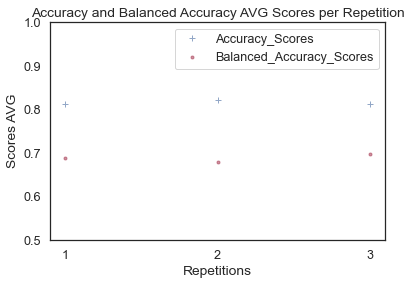

In [102]:
evaluate_cross_val_avg_via(RandomForestClassifier(), X_shap_top_11, y)

## Final Models

# **CHECK HERE???** **CHECK HERE???** **CHECK HERE???** **CHECK HERE???** **CHECK HERE???**

In [93]:
for i in range(NUM_EXPERIMENT_REPEAT):
    print(balanced_accuracy_score(ys_valid[i], final_models[i].predict(Xs_valid_shap[i])))

0.6363636363636364
0.6845238095238095
0.7023809523809523
0.8035714285714286
0.6607142857142857
0.7261904761904762
0.75
0.8095238095238095
0.6818181818181818
0.6136363636363636
0.6785714285714286
0.5178571428571429
0.7202380952380952
0.7857142857142857
0.5909090909090909
0.6130952380952381
0.6547619047619048
0.8095238095238095
0.7321428571428572
0.5714285714285714
0.7261904761904762
0.6964285714285714
0.7559523809523809
0.8035714285714286
0.7678571428571428
0.6590909090909092
0.7727272727272727
0.6818181818181819
0.5909090909090909
0.5952380952380952
0.6818181818181819
0.7380952380952381
0.7916666666666667
0.6428571428571428
0.7083333333333334
0.6590909090909091
0.6190476190476191
0.7916666666666667
0.625
0.7272727272727273
0.6607142857142857
0.46428571428571425
0.5595238095238095
0.7045454545454546
0.6309523809523809
0.7083333333333334
0.7202380952380952
0.5681818181818182
0.6011904761904762
0.5357142857142857


#### **Model I: ???** - - -  **[NotImplementedYet]**

In [103]:
final_model_randomized = randomized_search.best_estimator_

In [104]:
balanced_accuracy_score(y_valid, final_model_randomized.predict(X_valid_shap_top_11))

0.6814814814814815

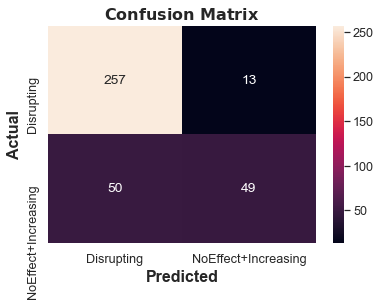

                     precision    recall  f1-score   support

         Disrupting       0.84      0.95      0.89       270
NoEffect+Increasing       0.79      0.49      0.61        99

           accuracy                           0.83       369
          macro avg       0.81      0.72      0.75       369
       weighted avg       0.82      0.83      0.82       369



In [105]:
# X_shap_top_11
cross_val_confusion_matrix_via(final_model_randomized,
                               X_shap_top_11, y, return_report=True)

#### **Model II: *RandomForestClassifier* fitted with train set** - - - **[NotImplementedYet]**

In [106]:
model_forest_ii = RandomForestClassifier(random_state=42)

model_forest_ii.fit(X_train_shap_top_11, y_train)

balanced_accuracy_score(y_valid, model_forest_ii.predict(X_valid_shap_top_11))

0.6564814814814814

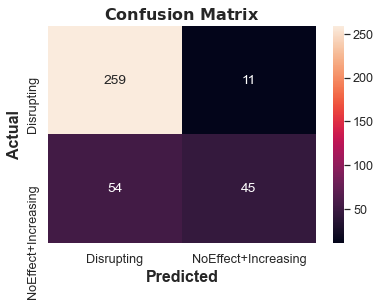

                     precision    recall  f1-score   support

         Disrupting       0.83      0.96      0.89       270
NoEffect+Increasing       0.80      0.45      0.58        99

           accuracy                           0.82       369
          macro avg       0.82      0.71      0.73       369
       weighted avg       0.82      0.82      0.81       369



In [107]:
# X_shap_top_11
cross_val_confusion_matrix_via(RandomForestClassifier(random_state=42),
                               X_shap_top_11, y, return_report=True)

#### **Model III: *RandomForestClassifier* fitted with whole train data** - - - **[NotImplementedYet]**

In [108]:
final_model_forest = RandomForestClassifier(random_state=42)

final_model_forest.fit(X_shap_top_11, y)

RandomForestClassifier(random_state=42)

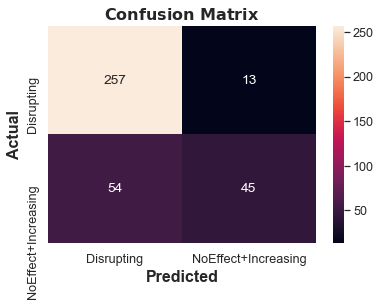

                     precision    recall  f1-score   support

         Disrupting       0.83      0.95      0.88       270
NoEffect+Increasing       0.78      0.45      0.57        99

           accuracy                           0.82       369
          macro avg       0.80      0.70      0.73       369
       weighted avg       0.81      0.82      0.80       369



In [109]:
# X_shap_top_11
cross_val_confusion_matrix_via(RandomForestClassifier(random_state=42),
                               X_shap_top_11, y, return_report=True)

## Final Features and Importances = = = **[not urgent]**

In [110]:
def plot_top_feature_importances_final(feature_importances, attributes_param):
    attributes = feature_columns
    feature_imp_series = pd.Series(feature_importances,
                                    index = attributes_param).sort_values(ascending=False)

    plt.figure(figsize=(5, 3))
    sns.set(style="white", font_scale=1.15)  # white, dark, whitegrid, darkgrid, ticks
    sns.barplot(x=feature_imp_series, y=feature_imp_series.index, palette="ch:s=-.2,r=.6")
    plt.xlabel('Feature Importances')
    plt.ylabel('Features')
    plt.title('Feature Importances of Selected Features')
    plt.show()

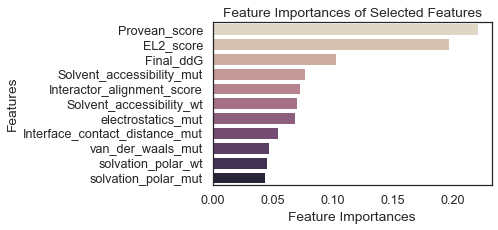

In [111]:
plot_top_feature_importances_final(randomized_search.best_estimator_.feature_importances_, X_shap_top_11.columns)

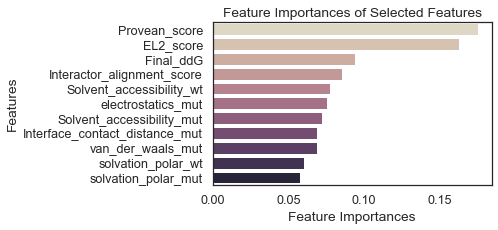

In [112]:
plot_top_feature_importances_final(final_model_forest.feature_importances_, X_shap_top_11.columns)

# Prediction on Cancer Data

## Declaring `X_brca`, `X_coad`, `X_ov`

In [95]:
# selected_columns_list = []
# for i in range(NUM_EXPERIMENT_REPEAT):
#     selected_columns_list.append(Xs_shap[i].columns.to_list())

NameError: name 'Xs_shap' is not defined

**BRCA**

In [97]:
Xs_brca = []
for i in range(NUM_EXPERIMENT_REPEAT):
    Xs_brca.append(target_brca_data[highly_selected_10_features].copy(deep=True))
    
for X_brca in Xs_brca:
    print("Dataframe dimensions: {}".format(X_brca.shape))
    print(X_brca.columns.to_list(), end='\n\n')
    # display(X_brca.head(1))

Dataframe dimensions: (4452, 10)
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']

Dataframe dimensions: (4452, 10)
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']

Dataframe dimensions: (4452, 10)
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']

Dataframe dimensions: (4452, 10)
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interacto

## Predicting `BRCA`

In [127]:
sample_entry = Xs_brca[0].iloc[[0], :].copy()

In [138]:
final_models[i].predict(sample_entry)[0]

0

In [134]:
final_models[i].classes_

array([0, 1], dtype=int64)

In [136]:
final_models[i].predict_proba(sample_entry)[0][0]

0.7428007788586357

In [140]:
sample_entry_predictions = []
for i in range(NUM_EXPERIMENT_REPEAT):
    sample_entry_predictions.append(final_models[i].predict(sample_entry)[0])

In [146]:
sample_entry_predictions.count(0), sample_entry_predictions.count(1)

(43, 7)

In [147]:
sample_entry_probabilities = []  # for class 0.
for i in range(NUM_EXPERIMENT_REPEAT):
    sample_entry_probabilities.append(final_models[i].predict_proba(sample_entry)[0][0])

In [149]:
np.array(sample_entry_probabilities).mean()

0.6181825136830748

In [113]:
final_models[i].predict(Xs_brca[0].iloc[[965], :])

array([1], dtype=int64)

In [119]:
final_models[i].predict_proba(Xs_brca[0].iloc[[965], :])

array([[0.3914809, 0.6085191]])

In [114]:
Xs_brca[0].iloc[[965], :]

,Provean_score,EL2_score,Final_ddG,Interactor_alignment_score,Matrix_score,Solvent_accessibility_wt,Solvent_accessibility_mut,van_der_waals_mut,Interactor_template_sequence_identity,Model/DOPE_score
965,-2.797,-0.231162,0.39033,0.966473,2.0,25.5451,35.5295,-15.0974,0.9965,-0.318183


In [99]:
brca_predictions_list = []
for i in tqdm(range(NUM_EXPERIMENT_REPEAT)):
    brca_predictions = final_models[i].predict(Xs_brca[i])
    brca_predictions_list.append(brca_predictions)

  0%|          | 0/50 [00:00<?, ?it/s]

In [166]:
predictions_value_counts = []
for i in range(EXPERIMENT_REPEAT):
    predictions_value_counts.append(
        (len(brca_predictions_list[i][brca_predictions_list[i]==0]), len(brca_predictions_list[i][brca_predictions_list[i]==1]))
    )

In [173]:
predictions_distributions_per_exp = pd.DataFrame(predictions_value_counts, index=[f'EXP_{i}' for i in range(1, EXPERIMENT_REPEAT + 1)])
predictions_distributions_per_exp.columns = ['Disrupting', 'NoEffect+Increasing']
predictions_distributions_per_exp['Total_entry'] = predictions_distributions_per_exp['Disrupting']\
                                                 + predictions_distributions_per_exp['NoEffect+Increasing']
predictions_distributions_per_exp

,Disrupting,NoEffect+Increasing,Total_entry
EXP_1,2227,2225,4452
EXP_2,2954,1498,4452
EXP_3,3477,975,4452
EXP_4,2367,2085,4452
EXP_5,2915,1537,4452
EXP_6,2907,1545,4452
EXP_7,2317,2135,4452
EXP_8,2650,1802,4452
EXP_9,2371,2081,4452
EXP_10,2749,1703,4452


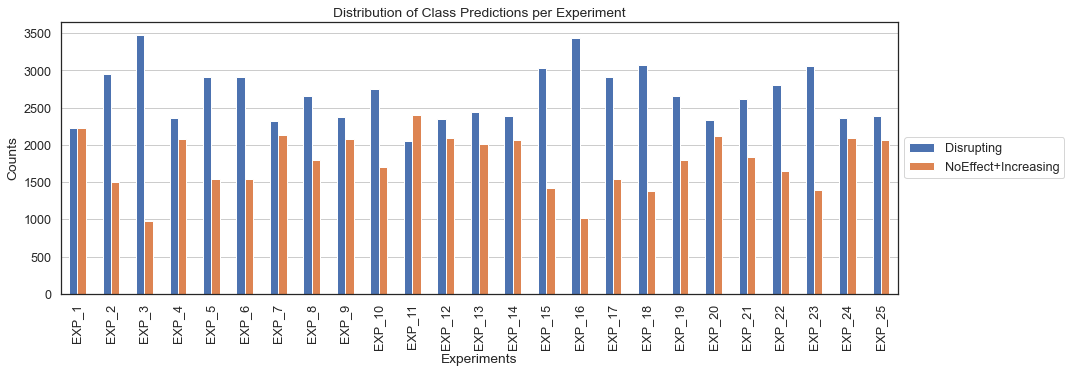

In [192]:
predictions_distributions_per_exp_table = predictions_distributions_per_exp.rename_axis('EXPERIMENT').reset_index()
predictions_distributions_per_exp_table
predictions_distributions_per_exp_table.plot(
    x="EXPERIMENT", y=["Disrupting", "NoEffect+Increasing"], kind="bar",
    figsize=(15, 5)
)
plt.grid(zorder=0, axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Distribution of Class Predictions per Experiment")
plt.xlabel("Experiments")
plt.ylabel("Counts")
plt.show()

## Merging Predictions with SNV Data

Merge prediction column with SNV data.

In [193]:
brca_predicted_datasets = []

for i in range(EXPERIMENT_REPEAT):
    # Make a copy of brca data
    brca_predicted_data = brca.copy(deep=True)
    
    # Insert prediction array values into data as first (0th) column.
    brca_predicted_data.insert(0, 'Predictions', brca_predictions_list[i])
    
    brca_predicted_datasets.append(brca_predicted_data)

In [194]:
brca_predicted_datasets[0].head()

,Predictions,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224
3,1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,571.0,71.7108,71.2911,46.7150,46.6809,1491.81,704.155,2195.98,2.88254,3.23468
4,1,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


In [195]:
brca_predicted_datasets[17].head()

,Predictions,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,571.0,58.4741,57.8248,44.4473,44.4473,1524.89,732.135,2257.02,3.01412,3.16742
1,0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,56.4873,56.3099,69.6442,69.6442,1500.95,795.265,2296.21,3.26366,4.98813
2,0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224
3,0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,571.0,71.7108,71.2911,46.7150,46.6809,1491.81,704.155,2195.98,2.88254,3.23468
4,0,Q9UKS6,Q9UKS6,R24H,done,interface,-,-,-,FCH,...,565.0,62.2267,62.0808,67.3261,67.3261,1555.45,776.3,2331.75,3.55240,4.79224


## Convert to 1-isomer: `Interactor_UniProt_ID`

$\textit{Interactor_UniProt_ID}$ column contains isomer proteins. Here, we convert them into primary representation (i.e. without dashes).

| Interactor_UniProt_ID |
--------------
| P38936     |
| P16473     |
| P16473-2   |
| P19793     |

In [200]:
def convert_primary_isomer(column_name, data):
    """
    Converts proteins into primary form representation, meaning dash-free from.
    E.g. 
        P16473-2 → P16473
    
    Parameters
    ----------
        column_name : <string>
            Name of the column where protein is stored.
        
        data : <DataFrame>
            The dataframe whose proteins will be processed in `column_name` column.
    
    Returns
    -------
        data : <DataFrame>
            Processed version of input dataframe.

    """
    
    # Protein names will be converted dashed-free version, if they contain.
    data[column_name] = data[column_name].apply(lambda x: x.split('-')[0])
    
    return data

In [201]:
for i in range(EXPERIMENT_REPEAT):
    # Converting proteins into primary isomer form in `Interactor_UniProt_ID` column.
    brca_predicted_datasets[i] = convert_primary_isomer('Interactor_UniProt_ID', brca_predicted_datasets[i])

## Dropping Entries which predicted as both `Decreasing` and `Increasing+NoEff`

Due to having different features from ELASPIC, the same $\textit{(protein, mutation, interactor)}$ may be classified both 0 and 1. We drop such instances.

In [202]:
def drop_invalid_predicted_entries(data):
    """
    Prediction data contains entries which for the same (PROTEIN, MUTATION, INTERACTOR), the predicted
    class is both 0 and 1. Find such instances, and drop them.
    
    Parameters
    ---------- 
        data : <DataFrame>
            The dataframe whose invalid predicted entries will be dropped.
    
    Returns
    -------
        data : <DataFrame>
            Processed version of input dataframe.    
        
        removed_entries_data : <DataFrame>
            A dataframe which contains removed entires.
    """
    
    entries = []
    entries_ix = []
    
    # For each (PROTEIN, MUTATION, INTERACTOR), capture the predicted class numbers.
    # If they are not all the same, then that (PROTEIN, MUTATION, INTERACTOR) row will be dropped.
    for index, row in data.iterrows():
        # Predicted class number(s) for current (PROTEIN, MUTATION, INTERACTOR) triplet.
        # Ideally, should be all the same. If not, then it will contain two class names.
        seach_data_predictions = data[(data["UniProt_ID"] == row["UniProt_ID"]) & 
                                      (data["Mutation"] == row["Mutation"]) &
                                      (data["Interactor_UniProt_ID"] == row["Interactor_UniProt_ID"])]["Predictions"].unique()
        
        # If seach_data_predictions contains class-0 and class-1 together, then it is an invalid predicted entries.
        if len(seach_data_predictions) > 1:
            entries.append((row["Predictions"], row["UniProt_ID"], row["Mutation"], row["Interactor_UniProt_ID"]))
            entries_ix.append(index)
      
    print_annotation("Removed entries:")
    removed_entries_data = pd.DataFrame(entries, 
                                        columns=["PREDICTIONS", "PROTEIN", "MUTATION", "INTERACTOR"])
    display(removed_entries_data)
    
    
    # Drop invalid predicted entries based on their index.
    data_dropped = data.drop(entries_ix, axis='index')
    
    # Reset index of the dataframe to avoid any possible errors.
    data_dropped.reset_index(drop=True, inplace=True)
    
    return data_dropped, removed_entries_data
            

In [234]:
brca_predicted_data_reduced_list = []
brca_removed_entries_list = []
for i in tqdm(range(EXPERIMENT_REPEAT)): 
    brca_predicted_data_reduced, brca_removed_entries = drop_invalid_predicted_entries(brca_predicted_datasets[i])
    brca_predicted_data_reduced_list.append(brca_predicted_data_reduced)
    brca_removed_entries_list.append(brca_removed_entries)

  0%|          | 0/25 [00:00<?, ?it/s]


Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9Y616,F419L,Q16288
1,0,Q9Y616,F419L,Q16288
2,0,Q14469,R46Q,Q96HZ4
3,1,Q14469,R46Q,Q96HZ4
4,1,Q14469,R46Q,Q96HZ4
...,...,...,...,...
352,1,Q9Y296,K108M,O43617
353,0,Q9UBE0,A304V,Q9UBT2
354,1,Q9UBE0,A304V,Q9UBT2
355,1,P55795,D146N,P31943



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9UKS6,R24H,Q9UNF0
1,0,Q9UKS6,R24H,Q9UNF0
2,0,P04637,R280K,Q13625
3,1,P04637,R280K,Q13625
4,1,P04637,R280K,Q13625
...,...,...,...,...
459,0,A9YTQ3,V75A,P27540
460,1,A9YTQ3,V75A,P27540
461,1,O75582,K296N,O75676
462,1,O75582,K296N,O75676



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9UKS6,R24H,Q9UNF0
1,0,Q9UKS6,R24H,Q9UNF0
2,1,P04637,R280K,P62993
3,1,P04637,R280K,P62993
4,1,P04637,R280K,P62993
...,...,...,...,...
500,1,A9YTQ3,V75A,P27540
501,0,A9YTQ3,V75A,P27540
502,1,O75582,K296N,O75676
503,0,O75582,K296N,O75676



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9UBN7,D567Y,Q96DB2
1,0,Q9UBN7,D567Y,Q96DB2
2,0,P04637,R280K,Q13625
3,1,P04637,R280K,Q13625
4,1,P04637,R280K,Q13625
...,...,...,...,...
592,1,O75582,K296N,O75676
593,0,P62805,I27F,P49450
594,1,P62805,I27F,P49450
595,0,P55795,D146N,P31943



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,P42336,G1049R,Q13535
1,0,P42336,G1049R,Q13535
2,0,P42336,G1049R,Q13535
3,0,P67775,E297K,Q13362
4,1,P67775,E297K,Q13362
...,...,...,...,...
304,0,O15539,D165N,P63096
305,1,O15539,D165N,P63096
306,0,Q14164,R162Q,P42771
307,1,Q14164,R162Q,P42771



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,P28072,M150V,P28074
1,1,P28072,M150V,P28074
2,0,P28072,M150V,P28074
3,1,P42338,E1051K,P43403
4,0,P42338,E1051K,P43403
...,...,...,...,...
389,0,P61587,L90I,Q13017
390,1,A9YTQ3,V75A,P27540
391,0,A9YTQ3,V75A,P27540
392,0,P55795,D146N,P31943



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9Y616,F419L,Q16288
1,0,Q9Y616,F419L,Q16288
2,0,Q9H4L4,Q399H,P61956
3,1,Q9H4L4,Q399H,P61956
4,0,P29466,R374L,Q14790
...,...,...,...,...
444,0,P61587,L90I,Q13017
445,0,O75582,K296N,Q15418
446,1,O75582,K296N,Q15418
447,0,P55795,D146N,P31943



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9Y616,F419L,Q16288
1,0,Q9Y616,F419L,Q16288
2,0,P04637,R280K,Q13625
3,1,P04637,R280K,Q13625
4,1,P04637,R280K,Q13625
...,...,...,...,...
580,0,Q9Y296,K108M,Q5T215
581,0,Q9Y296,K108M,O43617
582,1,Q9Y296,K108M,O43617
583,0,P55795,D146N,P31943



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9UBN7,D567Y,Q96DB2
1,0,Q9UBN7,D567Y,Q96DB2
2,1,Q9Y616,F419L,Q16288
3,0,Q9Y616,F419L,Q16288
4,1,Q9UL54,V301M,P46734
...,...,...,...,...
544,0,O15539,D165N,P04899
545,1,O15539,D165N,P63096
546,1,O15539,D165N,P04899
547,0,P55795,D146N,P31943



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9UKS6,R24H,Q9UNF0
1,0,Q9UKS6,R24H,Q9UNF0
2,1,Q9UL54,V301M,P46734
3,1,Q9UL54,V301M,P46734
4,0,Q9UL54,V301M,P46734
...,...,...,...,...
596,0,O15539,D165N,P09471
597,0,P61587,L90I,Q13017
598,0,P61587,L90I,Q13017
599,1,P61587,L90I,Q13017



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,0,Q9UBN7,D567Y,Q96DB2
1,1,Q9UBN7,D567Y,Q96DB2
2,0,P42336,G1049R,Q13535
3,1,P42336,G1049R,Q13535
4,1,P42336,G1049R,Q13535
...,...,...,...,...
623,1,O15539,D165N,P63096
624,1,O15539,D165N,P09471
625,0,O15539,D165N,P09471
626,0,P62324,D107N,Q9UIV1



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,0,P42336,H1047R,O00459
1,1,P42336,H1047R,O00459
2,1,Q9Y616,F419L,Q16288
3,0,Q9Y616,F419L,Q16288
4,0,P04637,R280K,Q13625
...,...,...,...,...
527,1,P00750,R339Q,P00749
528,1,P00750,R339Q,P00749
529,1,O75582,K296N,O75676
530,0,O75582,K296N,O75676



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9UBN7,D567Y,Q96DB2
1,0,Q9UBN7,D567Y,Q96DB2
2,0,Q13418,N202K,O15530
3,0,Q13418,N202K,O15530
4,1,Q13418,N202K,O15530
...,...,...,...,...
663,1,Q14164,R162Q,Q13153
664,1,A9YTQ3,V75A,P27540
665,0,A9YTQ3,V75A,P27540
666,1,P55795,D146N,P31943



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,P42336,H1047R,P27986
1,0,P42336,H1047R,P27986
2,0,Q9UBN7,D567Y,Q96DB2
3,1,Q9UBN7,D567Y,Q96DB2
4,1,P67775,E297K,Q15172
...,...,...,...,...
626,0,O95259,E633Q,Q8NCM2
627,1,O15539,D165N,P09471
628,0,O15539,D165N,P09471
629,0,O75582,K296N,Q15418



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9UL54,V301M,P46734
1,1,Q9UL54,V301M,P46734
2,0,Q9UL54,V301M,P46734
3,0,P67775,E297K,Q13362
4,1,P67775,E297K,Q13362
...,...,...,...,...
472,1,A9YTQ3,V75A,P27540
473,0,A9YTQ3,V75A,P27540
474,1,O75582,K296N,O75676
475,0,O75582,K296N,O75676



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,0,P29466,R374L,Q14790
1,1,P29466,R374L,Q14790
2,1,P29466,R374L,Q14790
3,1,P29466,R374L,Q14790
4,1,P29466,R374L,Q14790
...,...,...,...,...
382,1,P61587,L90I,O94827
383,0,P61587,L90I,O94827
384,0,P61587,L90I,O94827
385,1,A9YTQ3,V75A,P27540



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,P42336,G1049R,Q13535
1,0,P42336,G1049R,Q13535
2,0,P42336,G1049R,Q13535
3,0,P67775,E297K,Q13362
4,1,P67775,E297K,Q13362
...,...,...,...,...
304,0,O15539,D165N,P63096
305,1,O15539,D165N,P63096
306,0,Q14164,R162Q,P42771
307,1,Q14164,R162Q,P42771



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,0,P04637,R280K,P62993
1,0,P04637,R280K,P62993
2,1,P04637,R280K,P62993
3,0,P04637,R280K,P62993
4,0,P42336,G1049R,Q13535
...,...,...,...,...
473,0,O75582,K296N,O75676
474,0,P51168,S464F,P37088
475,0,P51168,S464F,P37088
476,0,P51168,S464F,P37088



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,0,P04637,R280K,Q13625
1,1,P04637,R280K,Q13625
2,1,P04637,R280K,Q13625
3,1,P42336,G1049R,Q13535
4,0,P42336,G1049R,Q13535
...,...,...,...,...
454,1,O75582,K296N,O75676
455,1,O75582,K296N,O75676
456,0,O75582,K296N,O75676
457,0,P55795,D146N,P31943



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,P42336,H1047R,P27986
1,0,P42336,H1047R,P27986
2,0,P04637,R280K,Q13625
3,1,P04637,R280K,Q13625
4,1,P04637,R280K,Q13625
...,...,...,...,...
624,1,Q9Y296,K108M,Q5T215
625,0,Q9Y296,K108M,Q5T215
626,0,O75582,K296N,O75676
627,1,O75582,K296N,O75676



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9Y616,F419L,Q16288
1,0,Q9Y616,F419L,Q16288
2,1,Q9UL54,V301M,P46734
3,1,Q9UL54,V301M,P46734
4,0,Q9UL54,V301M,P46734
...,...,...,...,...
342,1,O15539,D165N,P04899
343,1,A9YTQ3,V75A,P27540
344,0,A9YTQ3,V75A,P27540
345,1,P62805,I27F,P49450



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,1,Q9UKS6,R24H,Q9UNF0
1,0,Q9UKS6,R24H,Q9UNF0
2,1,Q9UBN7,D567Y,Q96DB2
3,0,Q9UBN7,D567Y,Q96DB2
4,0,P42336,C420R,Q92569
...,...,...,...,...
757,0,O75582,K296N,O75676
758,1,Q7L576,E662D,Q9Y2A7
759,0,Q7L576,E662D,Q9Y2A7
760,0,P49356,G244E,P49354



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,0,P20810,D466H,P17655
1,1,P20810,D466H,P17655
2,1,P20810,D466H,P17655
3,1,P67775,E297K,Q15173
4,1,P67775,E297K,Q15172
...,...,...,...,...
581,0,Q7L576,E662D,Q9Y2A7
582,1,P51168,S464F,P37088
583,1,P51168,S464F,P37088
584,1,P51168,S464F,P37088



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,0,P42336,C420R,Q92569
1,1,P42336,C420R,Q92569
2,1,Q9Y616,F419L,Q16288
3,0,Q9Y616,F419L,Q16288
4,1,Q9UL54,V301M,P46734
...,...,...,...,...
639,1,Q14164,R162Q,Q13153
640,1,A9YTQ3,V75A,P27540
641,0,A9YTQ3,V75A,P27540
642,1,P62324,D107N,Q9UIV1



Removed entries:
----------------


,PREDICTIONS,PROTEIN,MUTATION,INTERACTOR
0,0,P42336,H1047R,P27986
1,1,P42336,H1047R,P27986
2,1,P42336,H1047R,O00459
3,0,P42336,H1047R,O00459
4,0,P04637,R280K,P62993
...,...,...,...,...
492,1,A9YTQ3,V75A,P27540
493,0,A9YTQ3,V75A,P27540
494,1,O75582,K296N,O75676
495,0,O75582,K296N,O75676


In [235]:
[len(brca_predicted_data) for brca_predicted_data in brca_predicted_datasets]

[4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452,
 4452]

In [236]:
[len(brca_predicted_data_reduced) for brca_predicted_data_reduced in brca_predicted_data_reduced_list]

[4095,
 3988,
 3947,
 3855,
 4143,
 4058,
 4003,
 3867,
 3903,
 3851,
 3824,
 3920,
 3784,
 3821,
 3975,
 4065,
 4143,
 3974,
 3993,
 3823,
 4105,
 3690,
 3866,
 3808,
 3955]

In [237]:
[len(brca_removed_entries) for brca_removed_entries in brca_removed_entries_list]

[357,
 464,
 505,
 597,
 309,
 394,
 449,
 585,
 549,
 601,
 628,
 532,
 668,
 631,
 477,
 387,
 309,
 478,
 459,
 629,
 347,
 762,
 586,
 644,
 497]

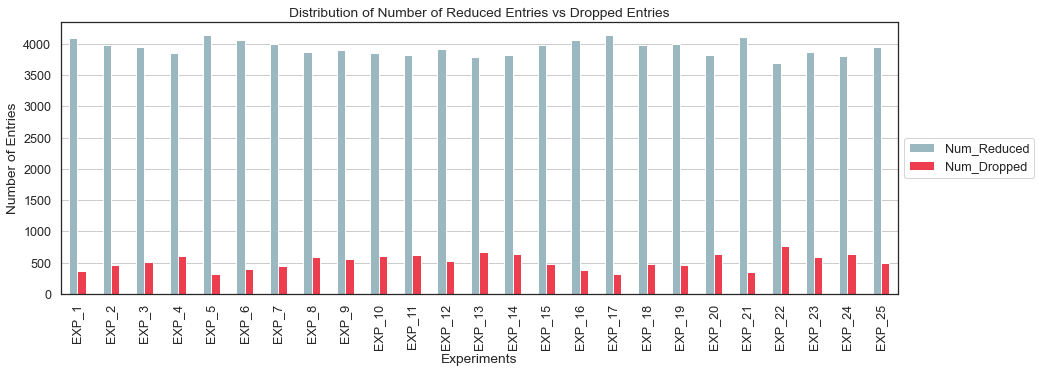

In [238]:
reduced_vs_dropped_counts_data = pd.DataFrame({
                        "Num_Reduced": [len(brca_predicted_data_reduced) for brca_predicted_data_reduced in brca_predicted_data_reduced_list],
                        "Num_Dropped": [len(brca_removed_entries) for brca_removed_entries in brca_removed_entries_list]
                    })

reduced_vs_dropped_counts_data.index = [f'EXP_{i}' for i in range(1, EXPERIMENT_REPEAT + 1)]
reduced_vs_dropped_counts_data.index.name = 'EXPERIMENT'
reduced_vs_dropped_counts_data
reduced_vs_dropped_counts_data.reset_index().plot(
     x="EXPERIMENT", y=["Num_Reduced", "Num_Dropped"], kind="bar",
     figsize=(15, 5), color=['#9bb7bf', '#ed3e4f']
)
plt.grid(zorder=0, axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Distribution of Number of Reduced Entries vs Dropped Entries")
plt.xlabel("Experiments")
plt.ylabel("Number of Entries")
plt.show()

## Predicted (*protein*, *mutation*, *interactor*) triplets

In [239]:
final_prediction_dataframes = []
for i in tqdm(range(EXPERIMENT_REPEAT)):
    final_prediction_data = brca_predicted_data_reduced_list[i][["Predictions", "UniProt_ID", "Mutation", "Interactor_UniProt_ID"]].copy()
    final_prediction_dataframes.append(final_prediction_data)

  0%|          | 0/25 [00:00<?, ?it/s]

## Drop Duplicated Entries in each `<tcga>_predicted_reduced_data`

By dropping duplicated entries in reduced version of data, we obtain unique **Prediction**, **Protein**, **Mutation**, **Interactor** rows.

In [240]:
for i in tqdm(range(EXPERIMENT_REPEAT)):
    # Drop duplicates by keeping the 'first' one.
    final_prediction_dataframes[i].drop_duplicates(keep="first", inplace=True)

  0%|          | 0/25 [00:00<?, ?it/s]

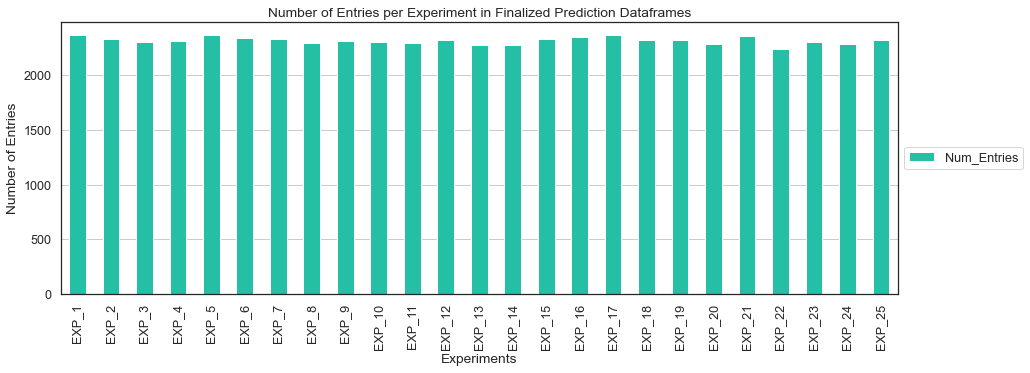

In [247]:
final_prediction_counts_data = pd.DataFrame({
                        "Num_Entries": [len(data) for data in final_prediction_dataframes],
                    })

final_prediction_counts_data.index = [f'EXP_{i}' for i in range(1, EXPERIMENT_REPEAT + 1)]
final_prediction_counts_data.index.name = 'EXPERIMENT'
final_prediction_counts_data
final_prediction_counts_data.reset_index().plot(
     x="EXPERIMENT", y=["Num_Entries"], kind="bar",
     figsize=(15, 5), color=['#24BFA5']
)
plt.grid(zorder=0, axis='y')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Number of Entries per Experiment in Finalized Prediction Dataframes")
plt.xlabel("Experiments")
plt.ylabel("Number of Entries")
plt.show()

In [296]:
def get_prediction_entry(protein, mutation, interactor, data):
    predictions = data[(data['UniProt_ID'] == protein) &
                       (data['Mutation'] == mutation) &
                       (data['Interactor_UniProt_ID'] == interactor)]['Predictions'].values
    
    if len(predictions) == 0:
        return 'NO_VOTE'  # meaning it was an entry such that we have predicted both 1 and 0 for that interactor.
    elif len(predictions) == 1:
        return predictions[0] # first element.
    else:
        raise ValueError('there should be one entry, thus one prediction value, but contains {} elements.'.format(len(predictions)))

In [298]:
get_prediction_entry('Q9UKS6', 'R24H', 'Q9BY11', final_prediction_dataframes[0])

1

In [306]:
def voting(data, final_prediction_datasets=final_prediction_dataframes):
    final_votes = []
    for index, row in tqdm(data.iterrows(), total=len(data)):
        protein, mutation, interactor = row['UniProt_ID'], row['Mutation'], row['Interactor_UniProt_ID']
        
        votes = []
        for final_prediction_data in final_prediction_dataframes:
            prediction = get_prediction_entry(protein, mutation, interactor, final_prediction_data)
            votes.append(prediction)
        
        final_votes.append((votes.count(0), votes.count(1), votes.count('NO_VOTE')))
        
    data['Num_preds_0'] = [item for item, _, _ in final_votes]
    data['Num_preds_1'] = [item for _, item, _ in final_votes]
    data['Num_preds_NO_VOTE'] = [item for _, _, item in final_votes]
    
    return data


In [309]:
brca_ensamble_prediction_data = brca[["UniProt_ID", "Mutation", "Interactor_UniProt_ID"]].copy()
brca_ensamble_prediction_data = convert_primary_isomer("Interactor_UniProt_ID", brca_ensamble_prediction_data)
brca_ensamble_prediction_data.drop_duplicates(keep="first", inplace=True)
brca_ensamble_prediction_data.reset_index(drop=True, inplace=True)
# brca_ensamble_prediction_data.apply(lambda voting: voting()) ## todo vectorication using 3 column as param.
brca_ensamble_prediction_data = voting(brca_ensamble_prediction_data)

  0%|          | 0/2448 [00:00<?, ?it/s]

In [313]:
brca_ensamble_prediction_data.head()

,UniProt_ID,Mutation,Interactor_UniProt_ID,Num_preds_0,Num_preds_1,Num_preds_NO_VOTE
0,Q9UKS6,R24H,Q9BY11,22,3,0
1,Q9UKS6,R24H,Q9UNF0,20,1,4
2,Q9UKS6,R24H,Q5TZC3,19,6,0
3,Q9UKS6,R24H,Q6FIA3,24,1,0
4,P42336,H1047R,Q13535,4,21,0


In [314]:
def max_votes(x):    
    if x['Num_preds_0'] > x['Num_preds_1'] and  x['Num_preds_0'] > x['Num_preds_NO_VOTE']:
        return 0
    elif x['Num_preds_1'] > x['Num_preds_0'] and  x['Num_preds_1'] > x['Num_preds_NO_VOTE']:
        return 1
    else:
        return 'NO_VOTE'

In [315]:
brca_ensamble_prediction_data['VOTED_PREDICTION'] = brca_ensamble_prediction_data.apply(max_votes, axis=1)

In [317]:
brca_ensamble_prediction_data

,UniProt_ID,Mutation,Interactor_UniProt_ID,Num_preds_0,Num_preds_1,Num_preds_NO_VOTE,VOTED_PREDICTION
0,Q9UKS6,R24H,Q9BY11,22,3,0,0
1,Q9UKS6,R24H,Q9UNF0,20,1,4,0
2,Q9UKS6,R24H,Q5TZC3,19,6,0,0
3,Q9UKS6,R24H,Q6FIA3,24,1,0,0
4,P42336,H1047R,Q13535,4,21,0,1
...,...,...,...,...,...,...,...
2443,P49356,G244E,P49354,23,1,1,0
2444,Q86YT6,R860S,Q96AX9,12,13,0,1
2445,P51168,S464F,P37088,9,14,2,1
2446,P51168,S464F,P51170,11,14,0,1


In [ ]:
brca_ensamble_prediction_data['VOTED_PREDICTION'].value_counts().plot(kind="bar");
plt.title('Distribution of predictions')
plt.xlabel('Predictions')
plt.ylabel('Count')
plt.grid()

# ====================================

In [139]:
# Drop duplicates by keeping the 'first' one.
brca_predicted_reduced_data.drop_duplicates(keep="first", inplace=True)
# coad_predicted_reduced_data.drop_duplicates(keep="first", inplace=True)
# ov_predicted_reduced_data.drop_duplicates(keep="first", inplace=True)

In [140]:
# Dimensions of unique rows in each tcga reduced data.
brca_predicted_reduced_data.shape, # coad_predicted_reduced_data.shape, ov_predicted_reduced_data.shape

((2334, 4),)

# Exporting Predictions (unique *protein*, *mutation*, *interactor*)

In [141]:
# BRCA
brca_predicted_reduced_data.to_csv("brca_predicted_reduced_data_shap_2021-07-27.csv", index=False)

In [142]:
# # COAD
# coad_predicted_reduced_data.to_csv("coad_predicted_reduced_data.csv", index=False)

In [143]:
# # OV
# ov_predicted_reduced_data.to_csv("ov_predicted_reduced_data.csv", index=False)

In [144]:
def plot_label_distribution_multiple(*dataframes_param):
    """
    Plot the number of `Disrupting` vs `Increasing + NoEffect` values in
    "Label_Predictions" column of given dataframes.
    
    The order: BRCA, COAD, OV.
    """
    
    brca_preds, coad_preds, ov_preds = dataframes_param
    
    def plot_label_distribution(data_param, tcga_name):
        sns.set(style="white", font_scale=1.50)  # white, dark, whitegrid, darkgrid, ticks
        ax = sns.barplot(x=data_param["Label_Predictions"].value_counts().index, 
                         y=data_param["Label_Predictions"].value_counts(),
                         palette="seismic")
        ax.set_title('Label Distributions of {} Predictions'.format(tcga_name))  # ch:s=-.2,r=.6, ocean, vlag, gray_r, Greys, , Purples, seismic
        ax.set_xlabel('Labels')
        ax.set_ylabel('Count')
        ax.set_xticklabels(['Disrupting', 'Increasing + NoEffect']);
    
    fig = plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plot_label_distribution(brca_preds, "BRCA")

#     plt.subplot(1, 3, 2)
#     plot_label_distribution(coad_preds, "COAD")

#     plt.subplot(1, 3, 3)
#     plot_label_distribution(ov_preds, "OV")
    
    fig.tight_layout(pad=3.0)
    plt.show()

Cancer data with duplicated triplets:

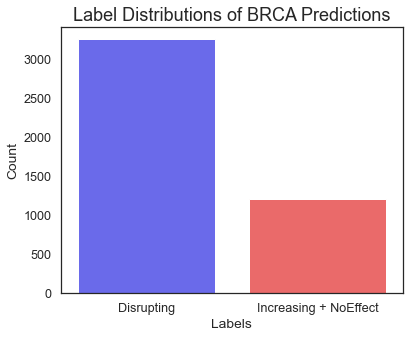

In [145]:
plot_label_distribution_multiple(
    pd.DataFrame({"Label_Predictions": brca_predictions}),
    None, None
   # pd.DataFrame({"Label_Predictions": coad_predictions}),
   # pd.DataFrame({"Label_Predictions": ov_predictions})
)

Cancer data *without* duplicated triplets:

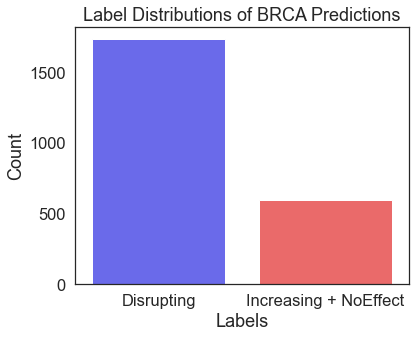

In [146]:
plot_label_distribution_multiple(
    pd.DataFrame({"Label_Predictions": brca_predicted_reduced_data["Predictions"]}),
    None, None
     # pd.DataFrame({"Label_Predictions": coad_predicted_reduced_data["Predictions"]}),
     # pd.DataFrame({"Label_Predictions": ov_predicted_reduced_data["Predictions"]})
)

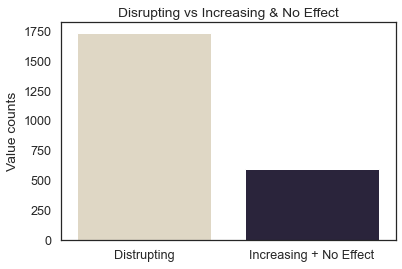

In [147]:
visualize_label_counts(brca_predicted_reduced_data, 'Predictions')

In [148]:
prediction_label_counts_data = pd.DataFrame(brca_predicted_reduced_data['Predictions'].value_counts())
prediction_label_counts_data.index = ['Disrupting', 'Increasing+NoEff']
prediction_label_counts_data

,Predictions
Disrupting,1737
Increasing+NoEff,597


# ========================

## Merging Predictions with SNV Data

Merge prediction column with SNV data.

In [149]:
# BRCA
# Make a copy of brca data
brca_predicted_data = brca.copy(deep=True)

# Insert prediction array values into data as first (0th) column.
brca_predicted_data.insert(0, 'Predictions', brca_predictions)

In [150]:
# # COAD
# # Make a copy of coad data
# coad_predicted_data = coad.copy(deep=True)

# # Insert prediction array values into data as first (0th) column.
# coad_predicted_data.insert(0, 'Predictions', coad_predictions)

In [151]:
# # OV
# # Make a copy of ov data
# ov_predicted_data = ov.copy(deep=True)

# # Insert prediction array values into data as first (0th) column.
# ov_predicted_data.insert(0, 'Predictions', ov_predictions)

In [152]:
pd.DataFrame({
    "BRCA": brca_predicted_data["Predictions"].value_counts().values,
    # "COAD": coad_predicted_data["Predictions"].value_counts().values,
    # "OV": ov_predicted_data["Predictions"].value_counts().values
}, index=["Disrupting", "Increasing+NoEff"])

,BRCA
Disrupting,3251
Increasing+NoEff,1201


In [153]:
brca_predicted_data["Predictions"].value_counts()

0    3251
1    1201
Name: Predictions, dtype: int64

In [154]:
# coad_predicted_data["Predictions"].value_counts()

In [155]:
# ov_predicted_data["Predictions"].value_counts()

In [156]:
pd.DataFrame({
    "BRCA": len(brca),
    # "COAD": len(coad),
    # "OV": len(ov)
}, index=["Predictions made"])

,BRCA
Predictions made,4452


# Exporting Predictions

In [157]:
# BRCA
brca_predicted_data.to_csv("brca_predicted_data_shap_2021-07-27.csv", index=False)

In [158]:
# # COAD
# coad_predicted_data.to_csv("coad_predicted_data.csv", index=False)

In [159]:
# # OV
# ov_predicted_data.to_csv("ov_predicted_data.csv", index=False)

In [160]:
brca_predicted_data[["Predictions", "UniProt_ID", "Mutation", "Interactor_UniProt_ID"]]

,Predictions,UniProt_ID,Mutation,Interactor_UniProt_ID
0,0,Q9UKS6,R24H,Q9BY11
1,0,Q9UKS6,R24H,Q9UNF0
2,0,Q9UKS6,R24H,Q9UNF0-2
3,0,Q9UKS6,R24H,Q5TZC3
4,0,Q9UKS6,R24H,Q6FIA3
...,...,...,...,...
4447,0,P51168,S464F,P37088-6
4448,0,P51168,S464F,P37088-5
4449,0,P51168,S464F,P51170
4450,0,P55795,D146N,P31943
